# Imports

In [1]:
from dqn_agent import DQNAgent
from ppo_agent import PPOAgent
from ffnn_agent import FFNNAgent
from data_processing import preprocess_all_data, load_preprocessed_dataset, get_activity, get_column_units, get_xy_from_data
from visualize import visualize_results, visualize_training, visualize_preprocessed_data
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load Data

In [2]:
# Load the preprocessed dataset
df = load_preprocessed_dataset()
target_features = ["Resting HR", "Max HR", "Age", "Weight", "Height"]

# Print unique values of target features
for feature in target_features:
    print(f"'{feature}' unique values: {df[feature].unique()}")

# Print unique values of 'Age'
print(f"\nUnique values of 'Age': {df['Age'].unique()}")

# Print how many rows there are for Activity ID 1 and 2
activity_counts = df['Activity ID'].value_counts()
print("\nActivity ID counts:")
for act_id in [1, 2]:
    count = activity_counts.get(act_id, 0)
    print(f"Activity ID {act_id}: {count} rows")

# Split based on Activity ID
df_val = df[df['Activity ID'] == 1].copy()
df_test = df[df['Activity ID'] == 2].copy()
df_train = df[~df['Activity ID'].isin([1, 2])].copy()

# Shuffle train set (optional but recommended)
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)

# Report split sizes
print(f"\nTrain samples (excluding Activity 1 & 2): {df_train.shape[0]}")
print(f"Validation samples (Activity 1): {df_val.shape[0]}")
print(f"Test samples (Activity 2): {df_test.shape[0]}")

# Get X and y splits
x_train, y_train = get_xy_from_data(df_train, target_features)
x_val, y_val = get_xy_from_data(df_val, target_features)
x_test, y_test = get_xy_from_data(df_test, target_features)

# Sanity check
print(f"\nX_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {x_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {x_test.shape}, y_test: {y_test.shape}")


---- Preprocessed Dataset Info ----
Number of rows: 61000
Number of columns: 39
-----------------------------------
'Resting HR' unique values: [75 74 68 58 70 60]
'Max HR' unique values: [193 195 189 196 194 197]
'Age' unique values: [27 25 31 24 26 23]
'Weight' unique values: [83 78 92 95 73 69 86]
'Height' unique values: [182 169 187 194 180 183 173]

Unique values of 'Age': [27 25 31 24 26 23]

Activity ID counts:
Activity ID 1: 7000 rows
Activity ID 2: 7000 rows

Train samples (excluding Activity 1 & 2): 47000
Validation samples (Activity 1): 7000
Test samples (Activity 2): 7000

X_train: (47000, 34), y_train: (47000, 5)
X_val: (7000, 34), y_val: (7000, 5)
X_test: (7000, 34), y_test: (7000, 5)


# Initialize system

In [3]:
continuous_columns = [
    'Timestamp',  'Hand Sensor - Temperature',
    'Hand Sensor - Accelerometer - X', 'Hand Sensor - Accelerometer - Y',
    'Hand Sensor - Accelerometer - Z', 'Hand Sensor - Gyroscope - X',
    'Hand Sensor - Gyroscope - Y', 'Hand Sensor - Gyroscope - Z',
    'Hand Sensor - Magnetometer - X', 'Hand Sensor - Magnetometer - Y',
    'Hand Sensor - Magnetometer - Z', 'Chest Sensor - Temperature',
    'Chest Sensor - Accelerometer - X', 'Chest Sensor - Accelerometer - Y',
    'Chest Sensor - Accelerometer - Z', 'Chest Sensor - Gyroscope - X',
    'Chest Sensor - Gyroscope - Y', 'Chest Sensor - Gyroscope - Z',
    'Chest Sensor - Magnetometer - X', 'Chest Sensor - Magnetometer - Y',
    'Chest Sensor - Magnetometer - Z', 'Ankle Sensor - Temperature',
    'Ankle Sensor - Accelerometer - X', 'Ankle Sensor - Accelerometer - Y',
    'Ankle Sensor - Accelerometer - Z', 'Ankle Sensor - Gyroscope - X',
    'Ankle Sensor - Gyroscope - Y', 'Ankle Sensor - Gyroscope - Z',
    'Ankle Sensor - Magnetometer - X', 'Ankle Sensor - Magnetometer - Y',
    'Ankle Sensor - Magnetometer - Z'
]

discrete_columns = [
     'Sex - Female', 'Heart Rate', "Resting HR", "Max HR", "Weight", "Height"
]

#discrete action size columns
dqn_config = {
    'state_size': 5,  
    'action_size': len(discrete_columns),  
    'hidden_size': 64,
    'lr': 1e-3,
    'gamma': 0.99,
    'batch_size': 64,
    'memory_size': 10000,
    'epsilon_start': 1.0,
    'epsilon_min': 0.01,
    'epsilon_decay': 0.995
}

#100 eps, 1k synth data, 1e-3 lr, 0.99 gamma + Background & Related Work
#continuous
ppo_config = {
    'state_size': 5,  
    'action_size': len(continuous_columns),   
    'hidden_size': 64,
    'lr': 1e-3,
    'gamma': 0.99,
    'clip_epsilon': 0.2,
    'update_epochs': 10,
    'batch_size': 64,
    'c1': 0.5,
    'c2': 0.01
}
classes = [1, 2, 3, 17, 16, 13, 4, 7, 6]

ffnn_config = {
    'input_size': df.shape[1] - 5,
    'hidden_sizes': [16, 16],
    'output_size': 5,
    'learning_rate': 0.001,
    'batch_size': 32,
    'epochs': 20,
    'type': 'regression',
    'classes': None
}

accuracy_reward_multiplier = 10

synthetic_data_amount = 1000
num_episodes = 100

dqn_agent = DQNAgent(**dqn_config)
ppo_agent = PPOAgent(**ppo_config)
ffnn_agent = FFNNAgent(**ffnn_config)
ffnn_agent_og = FFNNAgent(**ffnn_config)

Using device: cuda
Using device: cuda


# Training


Training FFNN on real data only (no synthetic data)...


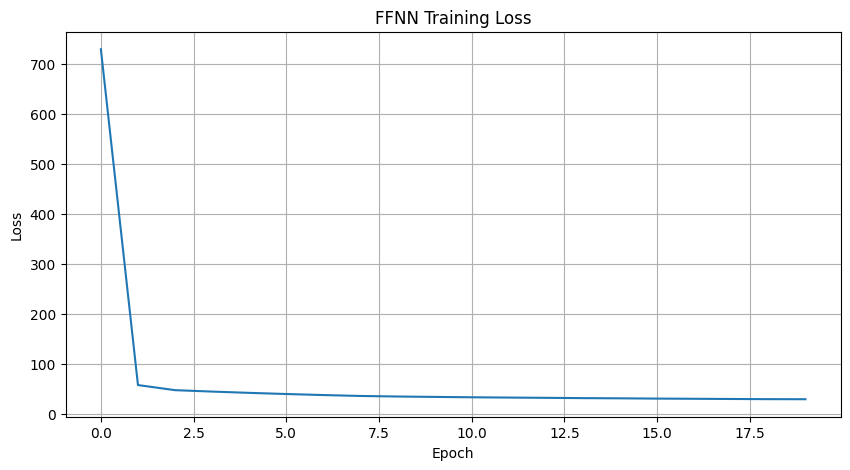


========== FFNN Baseline (No Synthetic Data) ==========
Train MSE: 29.2455 | Train MAE: 3.9358 | Female MSE: 6.1425
Val   MSE: 190.9068 | Val   MAE: 10.5693 | Female MSE: 30.4846
Test  MSE: 75.6585 | Test  MAE: 6.5454 | Female MSE: 7.5927

Episode 1/100: Generating Synthetic Data
Episode 1/100: Training FFNN


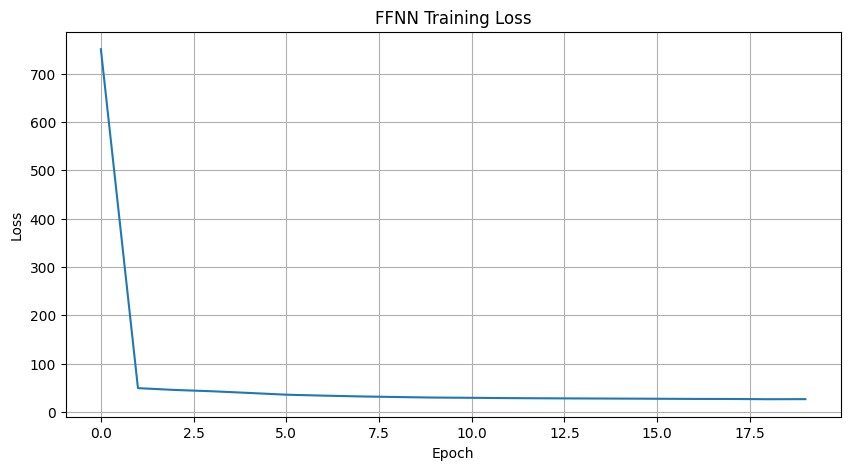

Episode 1/100: Evaluating FFNN
Episode 1/100 | Reward: -2348.6318
Train MSE: 26.0519 | Train Female MSE: 6.6786
Val MSE: 237.6636 | Val Female MSE: 81.8661
Test MSE: 60.8367 | Test Female MSE: 41.2936

--------------------------------

Episode 2/100: Generating Synthetic Data
Episode 2/100: Training FFNN


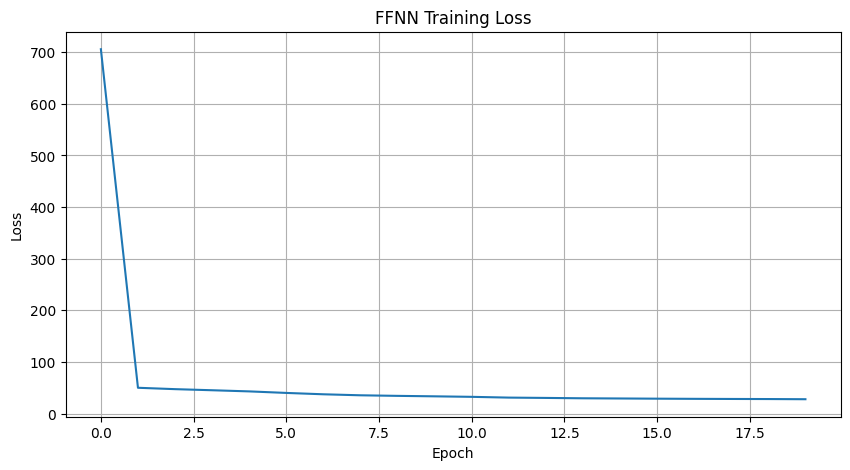

Episode 2/100: Evaluating FFNN
Episode 2/100 | Reward: -1620.5981
Train MSE: 27.4050 | Train Female MSE: 5.6850
Val MSE: 167.0013 | Val Female MSE: 176.7012
Test MSE: 56.2222 | Test Female MSE: 14.1999

--------------------------------

Episode 3/100: Generating Synthetic Data
Episode 3/100: Training FFNN


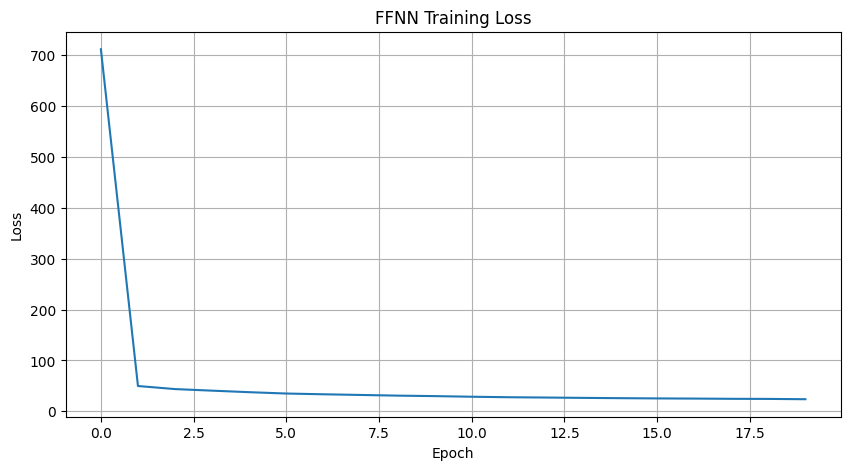

Episode 3/100: Evaluating FFNN
Episode 3/100 | Reward: -1703.8516
Train MSE: 23.4099 | Train Female MSE: 5.6077
Val MSE: 175.1224 | Val Female MSE: 55.2231
Test MSE: 55.7446 | Test Female MSE: 39.7517

--------------------------------

Episode 4/100: Generating Synthetic Data
Episode 4/100: Training FFNN


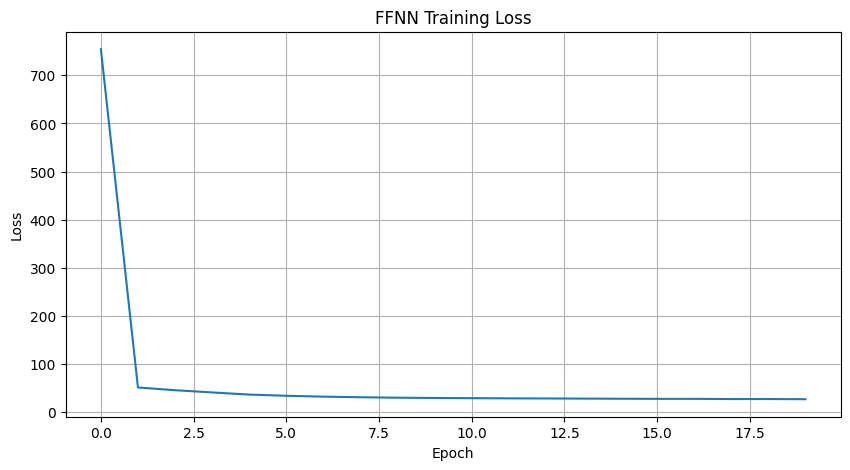

Episode 4/100: Evaluating FFNN
Episode 4/100 | Reward: -815.3737
Train MSE: 26.9296 | Train Female MSE: 6.9412
Val MSE: 86.0556 | Val Female MSE: 11.5623
Test MSE: 50.6971 | Test Female MSE: 7.7910

--------------------------------

Episode 5/100: Generating Synthetic Data
Episode 5/100: Training FFNN


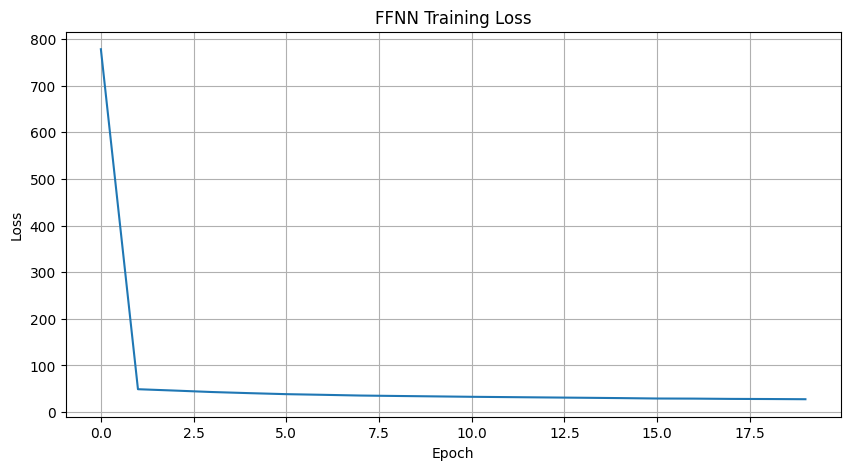

Episode 5/100: Evaluating FFNN
Episode 5/100 | Reward: -4124.7874
Train MSE: 27.4682 | Train Female MSE: 6.7922
Val MSE: 418.0125 | Val Female MSE: 149.9176
Test MSE: 47.1706 | Test Female MSE: 7.3982

--------------------------------

Episode 6/100: Generating Synthetic Data
Episode 6/100: Training FFNN


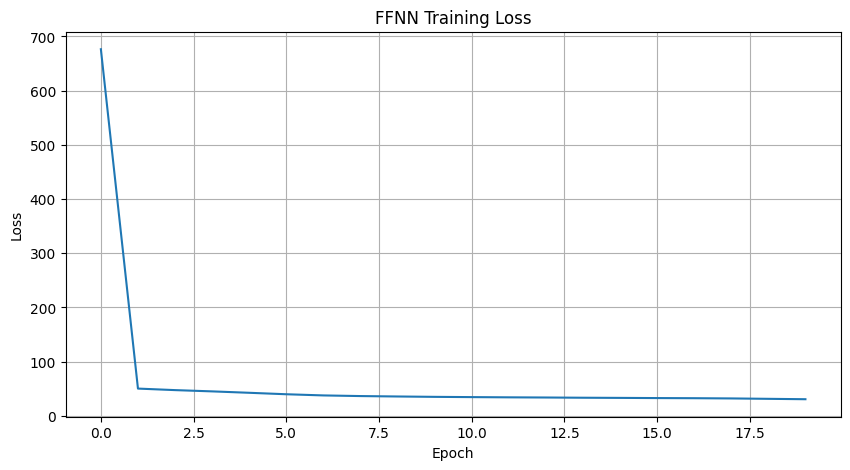

Episode 6/100: Evaluating FFNN
Episode 6/100 | Reward: -2932.7261
Train MSE: 30.2580 | Train Female MSE: 6.3083
Val MSE: 300.5843 | Val Female MSE: 87.6617
Test MSE: 66.3073 | Test Female MSE: 9.4896

--------------------------------

Episode 7/100: Generating Synthetic Data
Episode 7/100: Training FFNN


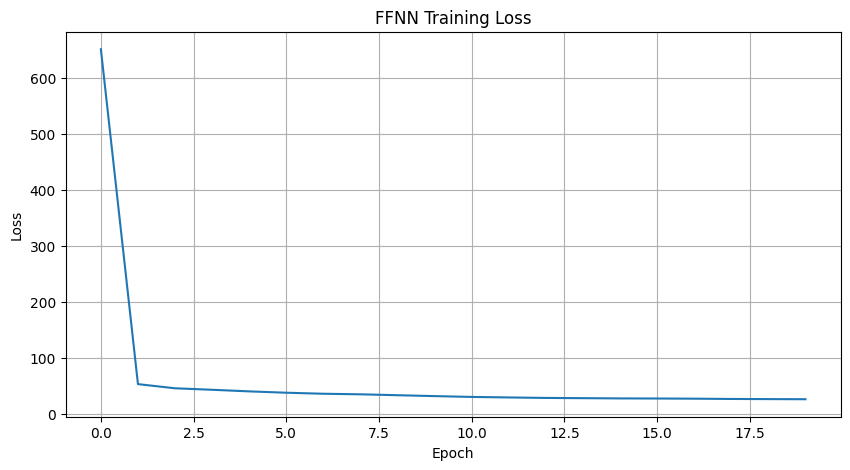

Episode 7/100: Evaluating FFNN
Episode 7/100 | Reward: -1987.8024
Train MSE: 26.7634 | Train Female MSE: 7.2517
Val MSE: 206.0392 | Val Female MSE: 98.4502
Test MSE: 62.3665 | Test Female MSE: 11.1788

--------------------------------

Episode 8/100: Generating Synthetic Data
Episode 8/100: Training FFNN


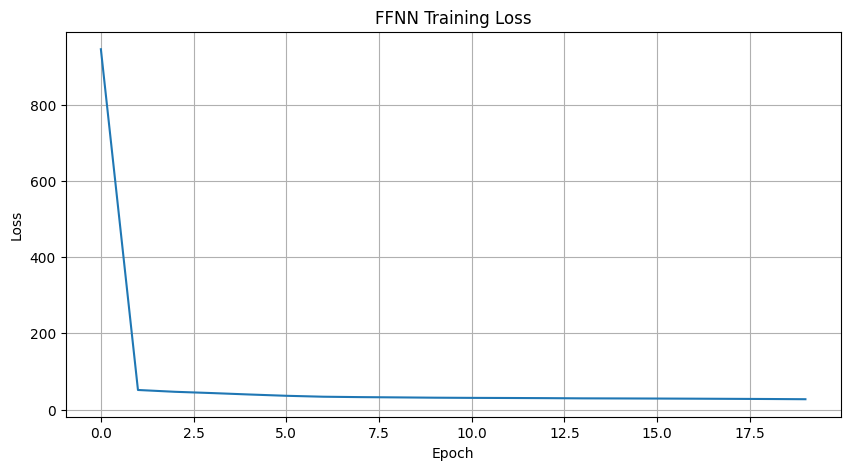

Episode 8/100: Evaluating FFNN
Episode 8/100 | Reward: -2821.1796
Train MSE: 26.4677 | Train Female MSE: 6.0813
Val MSE: 289.6384 | Val Female MSE: 233.9773
Test MSE: 71.7242 | Test Female MSE: 33.8250

--------------------------------

Episode 9/100: Generating Synthetic Data
Episode 9/100: Training FFNN


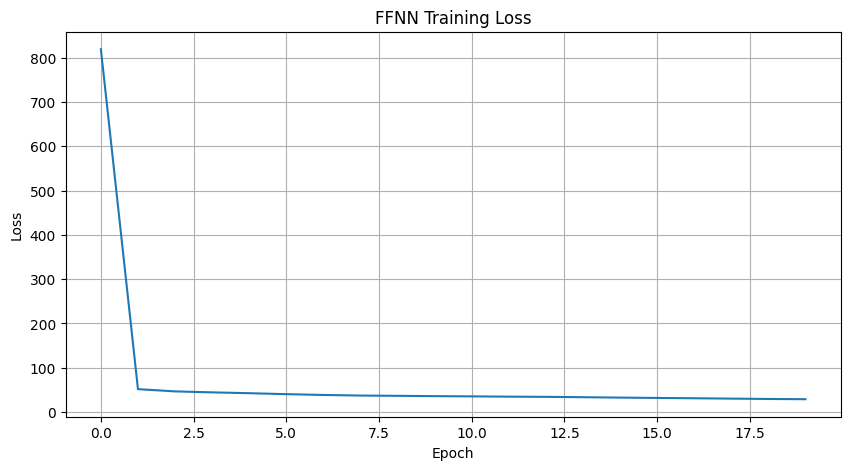

Episode 9/100: Evaluating FFNN
Episode 9/100 | Reward: -680.9334
Train MSE: 28.1971 | Train Female MSE: 5.1539
Val MSE: 76.5444 | Val Female MSE: 5.9664
Test MSE: 55.1988 | Test Female MSE: 8.4514

--------------------------------

Episode 10/100: Generating Synthetic Data
Episode 10/100: Training FFNN


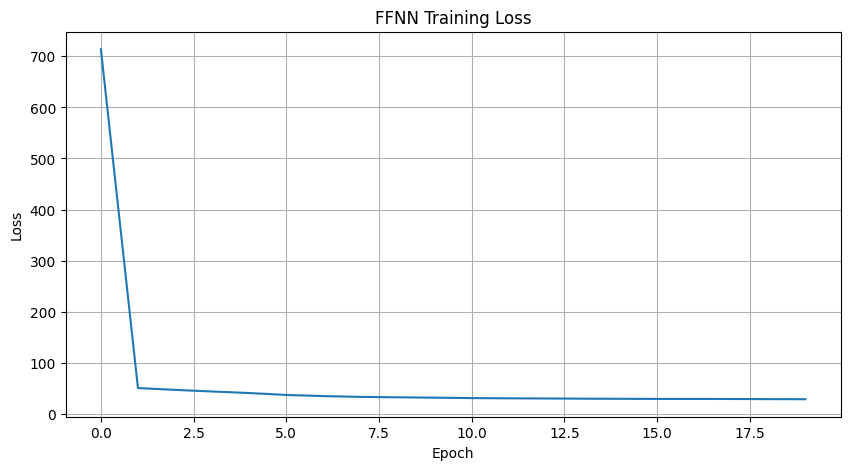

Episode 10/100: Evaluating FFNN
Episode 10/100 | Reward: -1144.4102
Train MSE: 28.3546 | Train Female MSE: 7.1922
Val MSE: 121.6384 | Val Female MSE: 48.7850
Test MSE: 58.5825 | Test Female MSE: 3.6440

--------------------------------

Episode 11/100: Generating Synthetic Data
Episode 11/100: Training FFNN


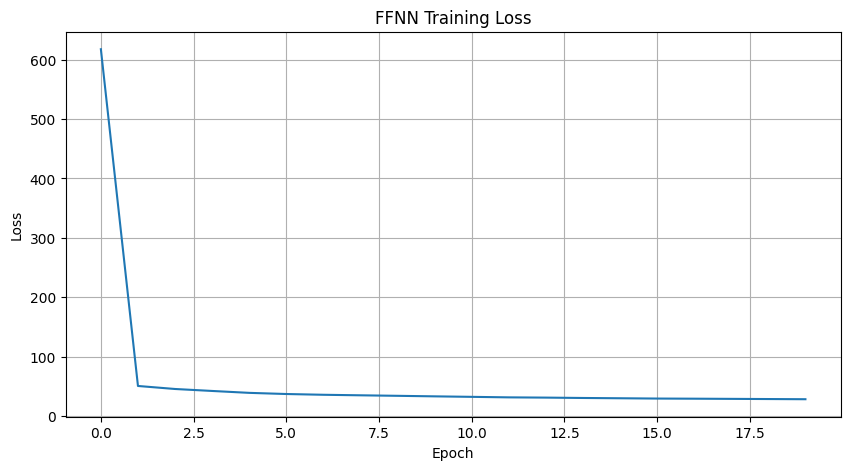

Episode 11/100: Evaluating FFNN
Episode 11/100 | Reward: -1189.2813
Train MSE: 27.8908 | Train Female MSE: 5.4511
Val MSE: 125.3137 | Val Female MSE: 10.6703
Test MSE: 69.4736 | Test Female MSE: 5.5724

--------------------------------

Episode 12/100: Generating Synthetic Data
Episode 12/100: Training FFNN


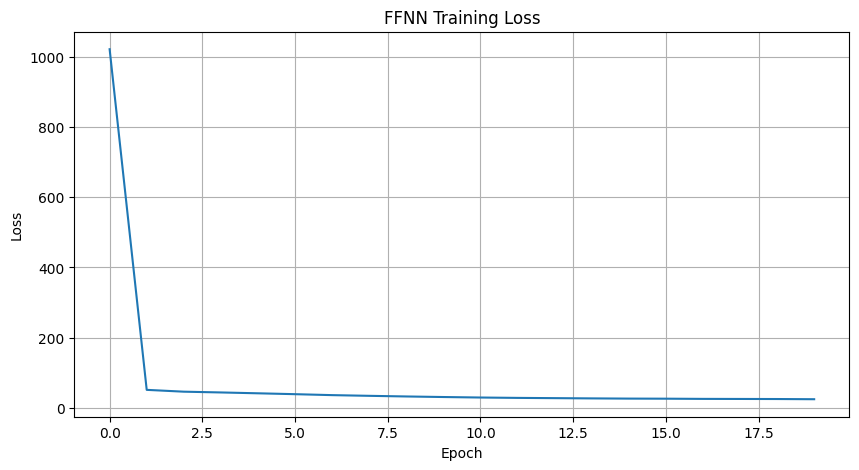

Episode 12/100: Evaluating FFNN
Episode 12/100 | Reward: -1216.8562
Train MSE: 25.4155 | Train Female MSE: 7.3079
Val MSE: 129.2074 | Val Female MSE: 54.2222
Test MSE: 109.6277 | Test Female MSE: 44.7443

--------------------------------

Episode 13/100: Generating Synthetic Data
Episode 13/100: Training FFNN


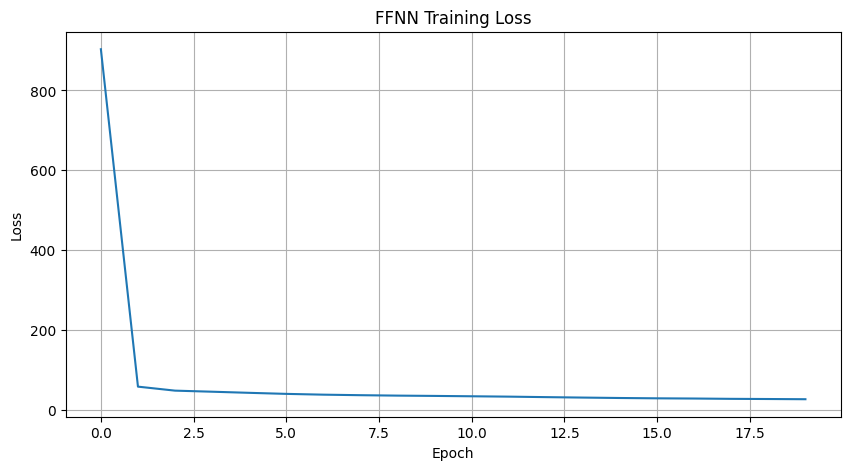

Episode 13/100: Evaluating FFNN
Episode 13/100 | Reward: -843.8424
Train MSE: 26.0202 | Train Female MSE: 5.5792
Val MSE: 95.6814 | Val Female MSE: 52.1944
Test MSE: 67.0791 | Test Female MSE: 7.0909

--------------------------------

Episode 14/100: Generating Synthetic Data
Episode 14/100: Training FFNN


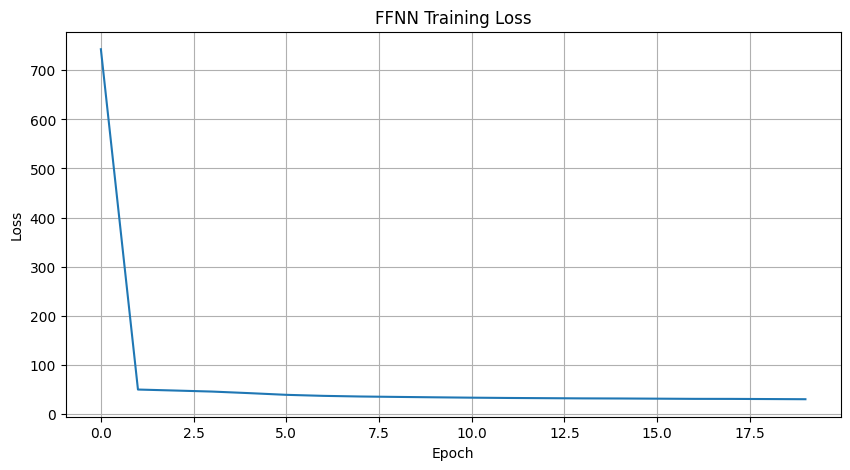

Episode 14/100: Evaluating FFNN
Episode 14/100 | Reward: -5095.7446
Train MSE: 29.3303 | Train Female MSE: 5.6850
Val MSE: 520.7482 | Val Female MSE: 171.8043
Test MSE: 64.5402 | Test Female MSE: 5.5338

--------------------------------

Episode 15/100: Generating Synthetic Data
Episode 15/100: Training FFNN


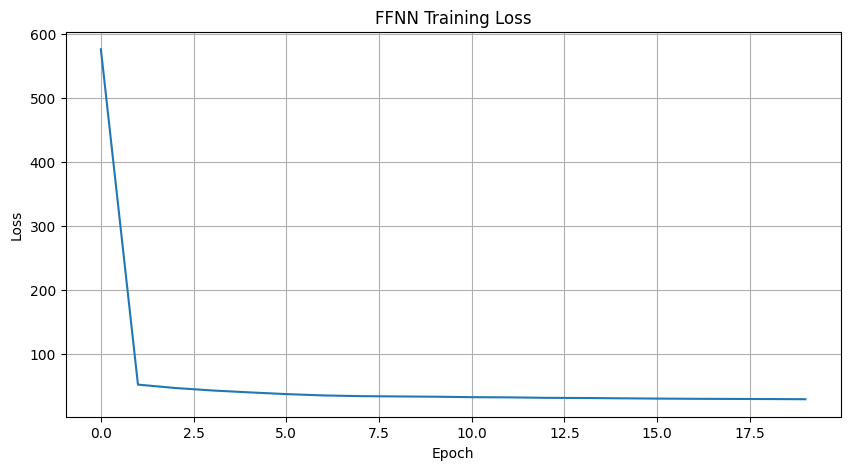

Episode 15/100: Evaluating FFNN
Episode 15/100 | Reward: -795.9169
Train MSE: 28.3792 | Train Female MSE: 6.3988
Val MSE: 88.9141 | Val Female MSE: 22.4338
Test MSE: 43.2668 | Test Female MSE: 3.3207

--------------------------------

Episode 16/100: Generating Synthetic Data
Episode 16/100: Training FFNN


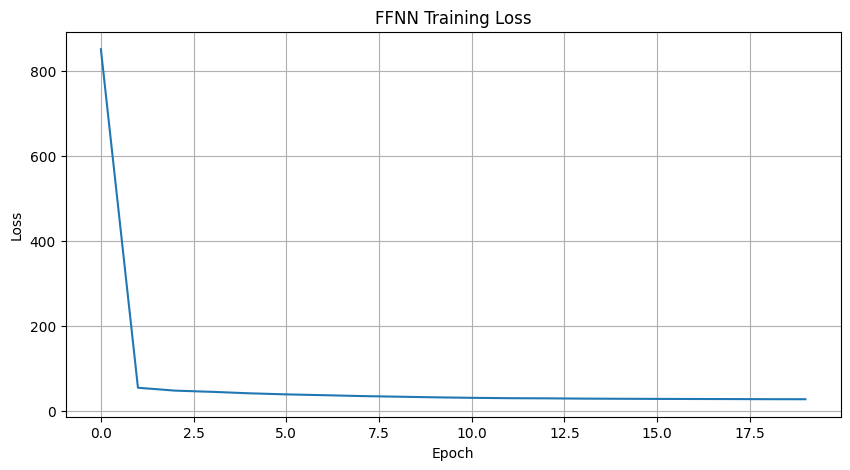

Episode 16/100: Evaluating FFNN
Episode 16/100 | Reward: -772.1464
Train MSE: 26.3126 | Train Female MSE: 6.1312
Val MSE: 85.2581 | Val Female MSE: 44.5304
Test MSE: 74.2361 | Test Female MSE: 12.6423

--------------------------------

Episode 17/100: Generating Synthetic Data
Episode 17/100: Training FFNN


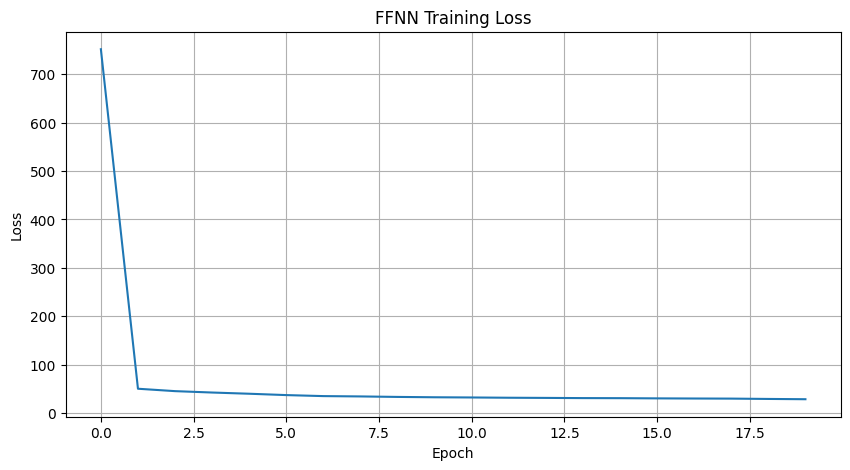

Episode 17/100: Evaluating FFNN
Episode 17/100 | Reward: -982.0787
Train MSE: 28.5888 | Train Female MSE: 6.1876
Val MSE: 106.4525 | Val Female MSE: 26.1758
Test MSE: 53.5980 | Test Female MSE: 5.0952

--------------------------------

Episode 18/100: Generating Synthetic Data
Episode 18/100: Training FFNN


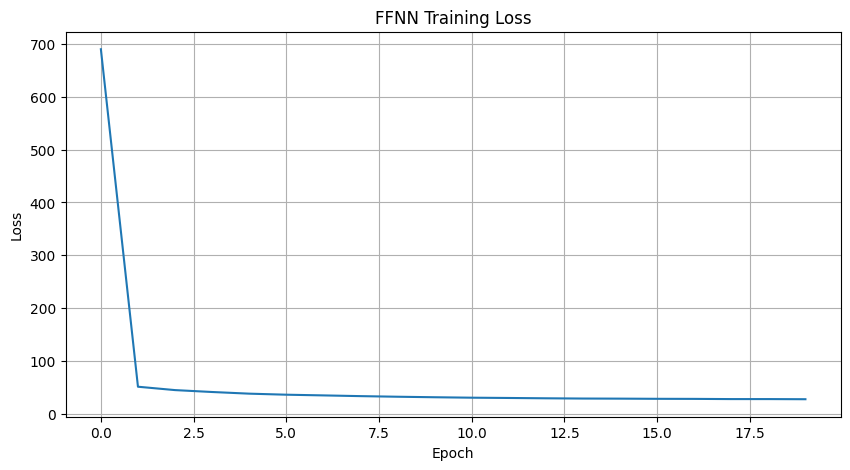

Episode 18/100: Evaluating FFNN
Episode 18/100 | Reward: -762.4421
Train MSE: 29.9699 | Train Female MSE: 7.0754
Val MSE: 85.0540 | Val Female MSE: 14.0569
Test MSE: 93.4259 | Test Female MSE: 29.4132

--------------------------------

Episode 19/100: Generating Synthetic Data
Episode 19/100: Training FFNN


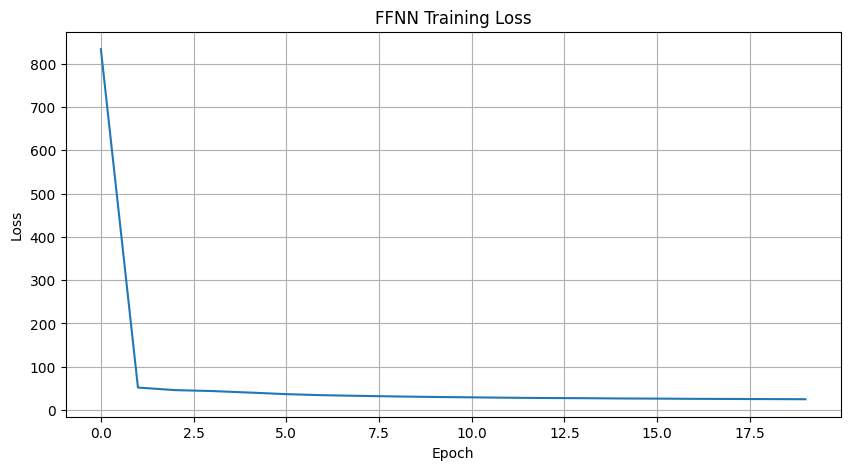

Episode 19/100: Evaluating FFNN
Episode 19/100 | Reward: -1215.9683
Train MSE: 24.0498 | Train Female MSE: 4.8591
Val MSE: 130.2191 | Val Female MSE: 49.3199
Test MSE: 50.6231 | Test Female MSE: 6.7159

--------------------------------

Episode 20/100: Generating Synthetic Data
Episode 20/100: Training FFNN


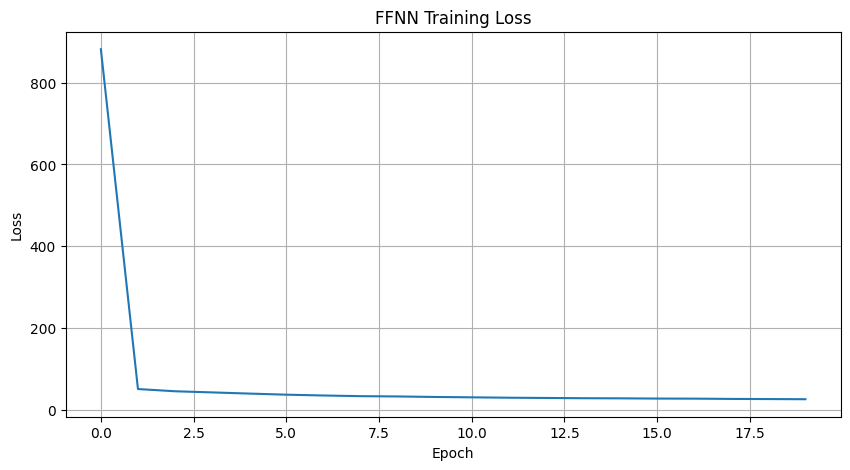

Episode 20/100: Evaluating FFNN
Episode 20/100 | Reward: -743.7357
Train MSE: 25.8432 | Train Female MSE: 5.5080
Val MSE: 82.2376 | Val Female MSE: 21.2819
Test MSE: 72.2061 | Test Female MSE: 20.8138

--------------------------------

Episode 21/100: Generating Synthetic Data
Episode 21/100: Training FFNN


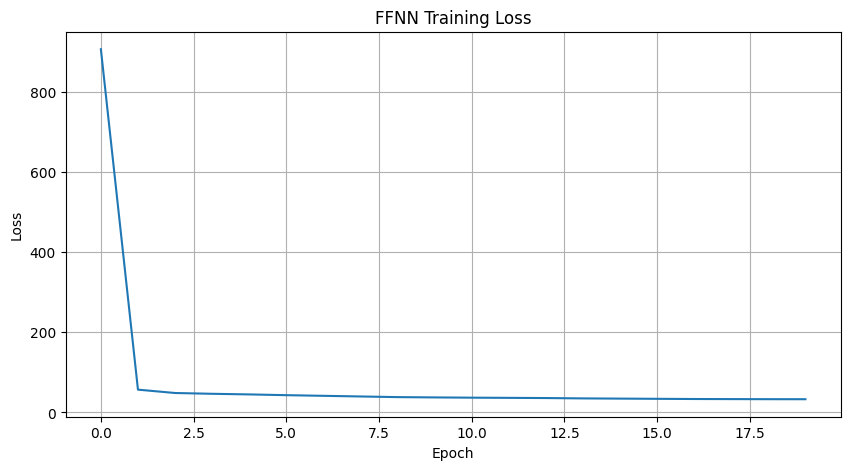

Episode 21/100: Evaluating FFNN
Episode 21/100 | Reward: -1098.9980
Train MSE: 32.8333 | Train Female MSE: 6.2153
Val MSE: 117.0030 | Val Female MSE: 23.4876
Test MSE: 56.3784 | Test Female MSE: 7.9719

--------------------------------

Episode 22/100: Generating Synthetic Data
Episode 22/100: Training FFNN


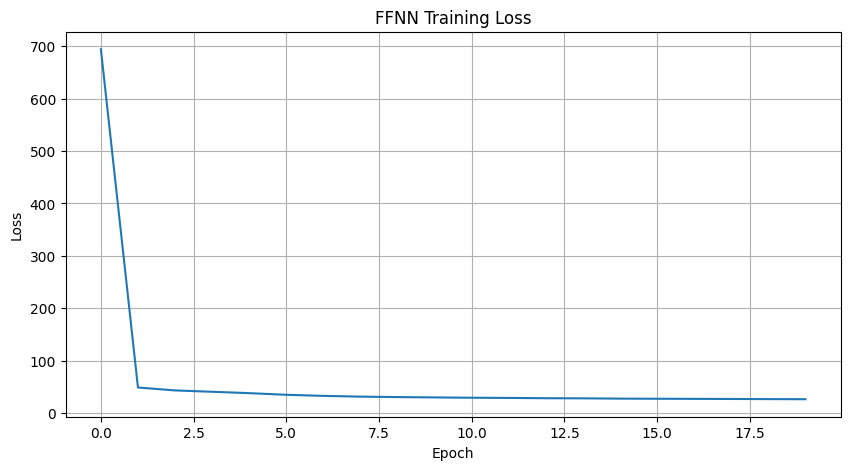

Episode 22/100: Evaluating FFNN
Episode 22/100 | Reward: -1992.0500
Train MSE: 26.4564 | Train Female MSE: 6.2028
Val MSE: 206.3568 | Val Female MSE: 114.6411
Test MSE: 73.4151 | Test Female MSE: 14.3284

--------------------------------

Episode 23/100: Generating Synthetic Data
Episode 23/100: Training FFNN


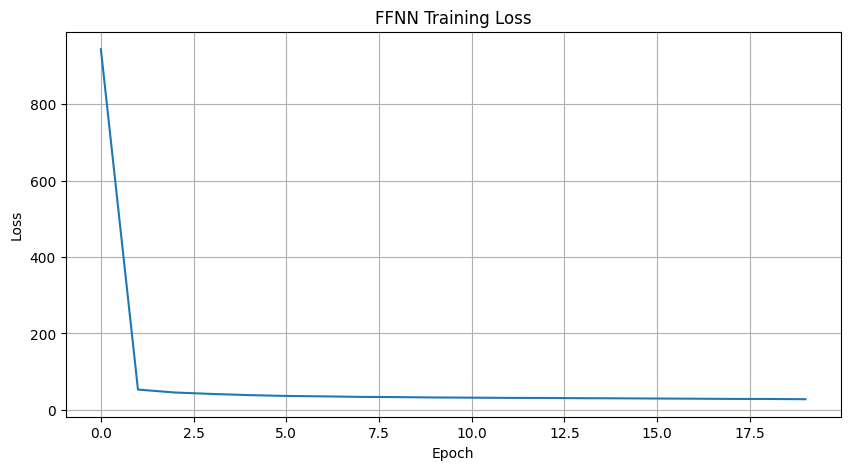

Episode 23/100: Evaluating FFNN
Episode 23/100 | Reward: -1620.6249
Train MSE: 27.5584 | Train Female MSE: 5.6793
Val MSE: 169.7126 | Val Female MSE: 11.6268
Test MSE: 63.6651 | Test Female MSE: 3.5831

--------------------------------

Episode 24/100: Generating Synthetic Data
Episode 24/100: Training FFNN


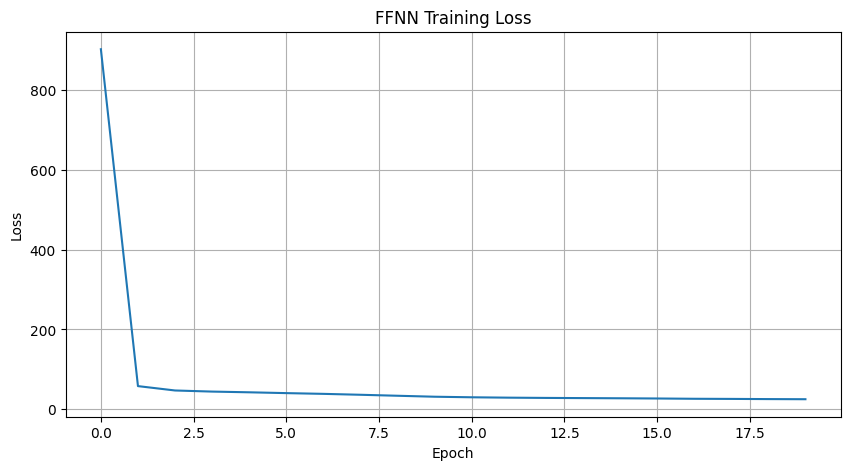

Episode 24/100: Evaluating FFNN
Episode 24/100 | Reward: -561.8267
Train MSE: 24.7675 | Train Female MSE: 5.4958
Val MSE: 62.9773 | Val Female MSE: 62.1548
Test MSE: 47.9868 | Test Female MSE: 2.8018

--------------------------------

Episode 25/100: Generating Synthetic Data
Episode 25/100: Training FFNN


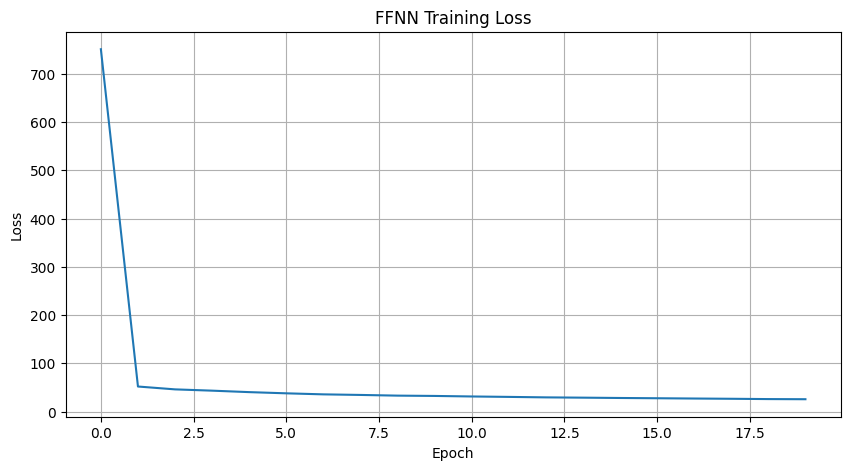

Episode 25/100: Evaluating FFNN
Episode 25/100 | Reward: -1122.7515
Train MSE: 25.0582 | Train Female MSE: 5.7956
Val MSE: 118.7172 | Val Female MSE: 15.4490
Test MSE: 44.3134 | Test Female MSE: 6.7379

--------------------------------

Episode 26/100: Generating Synthetic Data
Episode 26/100: Training FFNN


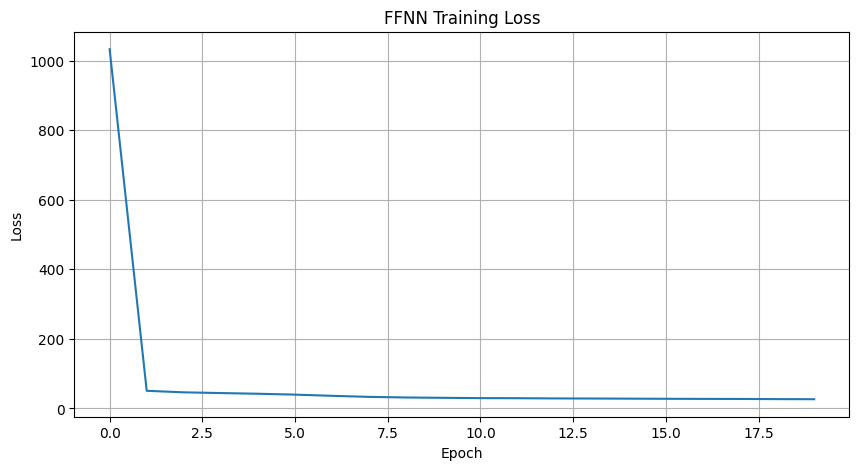

Episode 26/100: Evaluating FFNN
Episode 26/100 | Reward: -2056.1299
Train MSE: 26.0178 | Train Female MSE: 4.8330
Val MSE: 212.4590 | Val Female MSE: 18.5536
Test MSE: 149.7862 | Test Female MSE: 26.1909

--------------------------------

Episode 27/100: Generating Synthetic Data
Episode 27/100: Training FFNN


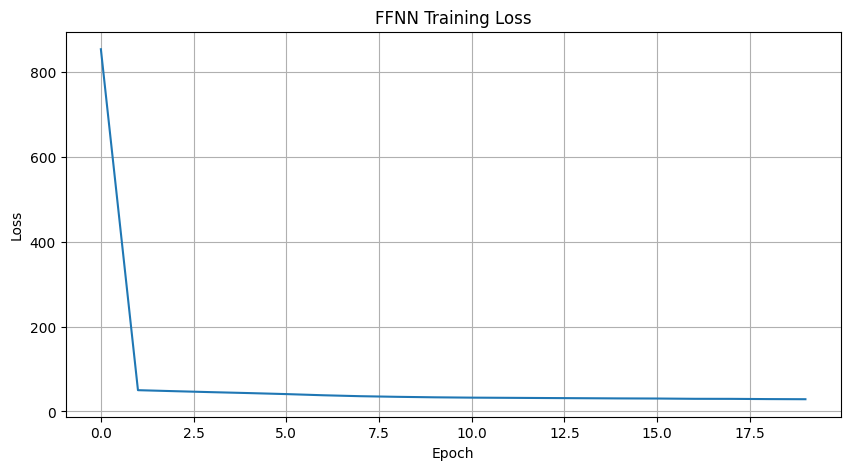

Episode 27/100: Evaluating FFNN
Episode 27/100 | Reward: -947.9662
Train MSE: 30.0683 | Train Female MSE: 7.7114
Val MSE: 99.9931 | Val Female MSE: 13.7430
Test MSE: 52.1297 | Test Female MSE: 6.0309

--------------------------------

Episode 28/100: Generating Synthetic Data
Episode 28/100: Training FFNN


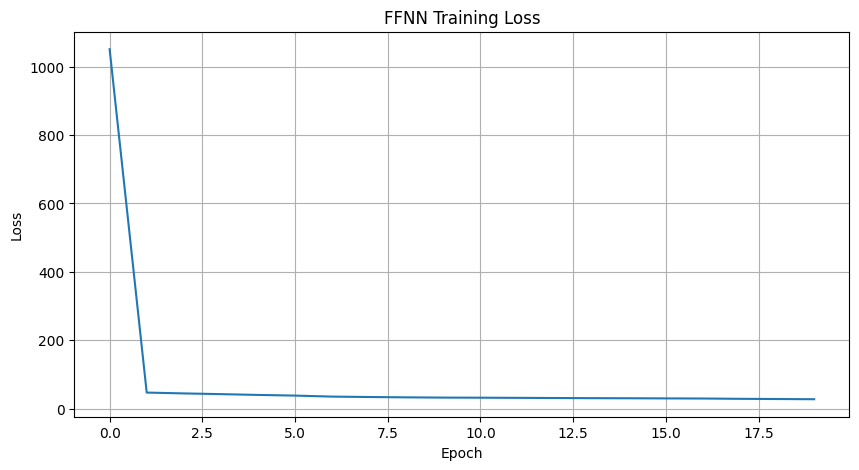

Episode 28/100: Evaluating FFNN
Episode 28/100 | Reward: -1499.6689
Train MSE: 26.8771 | Train Female MSE: 5.6429
Val MSE: 153.5100 | Val Female MSE: 86.2508
Test MSE: 83.5682 | Test Female MSE: 32.9453

--------------------------------

Episode 29/100: Generating Synthetic Data
Episode 29/100: Training FFNN


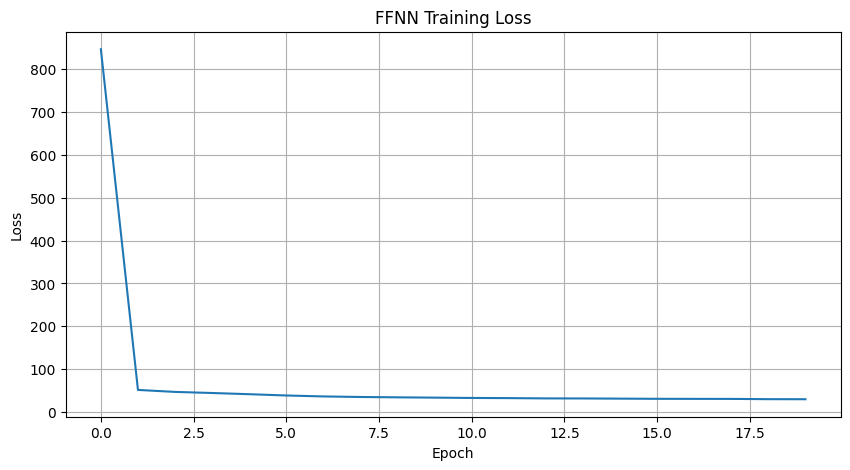

Episode 29/100: Evaluating FFNN
Episode 29/100 | Reward: -1669.8406
Train MSE: 29.4181 | Train Female MSE: 5.9243
Val MSE: 170.6128 | Val Female MSE: 39.9393
Test MSE: 64.6248 | Test Female MSE: 4.7772

--------------------------------

Episode 30/100: Generating Synthetic Data
Episode 30/100: Training FFNN


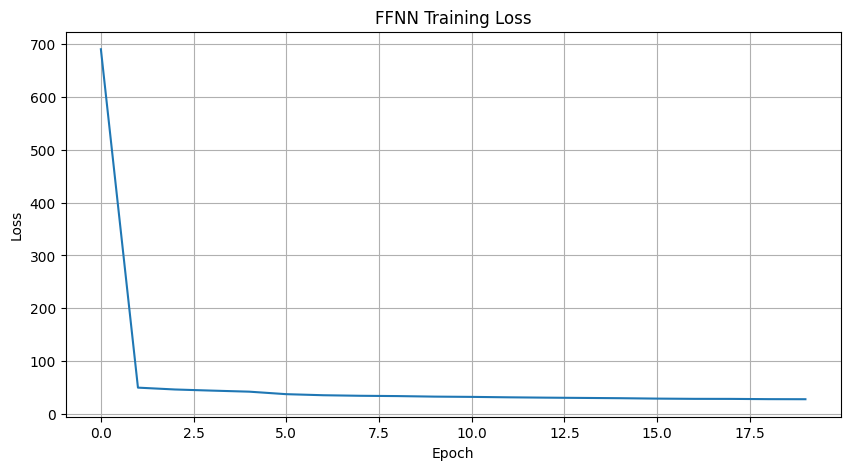

Episode 30/100: Evaluating FFNN
Episode 30/100 | Reward: -1754.0123
Train MSE: 26.8177 | Train Female MSE: 4.4901
Val MSE: 178.9704 | Val Female MSE: 97.2325
Test MSE: 76.9169 | Test Female MSE: 25.3461

--------------------------------

Episode 31/100: Generating Synthetic Data
Episode 31/100: Training FFNN


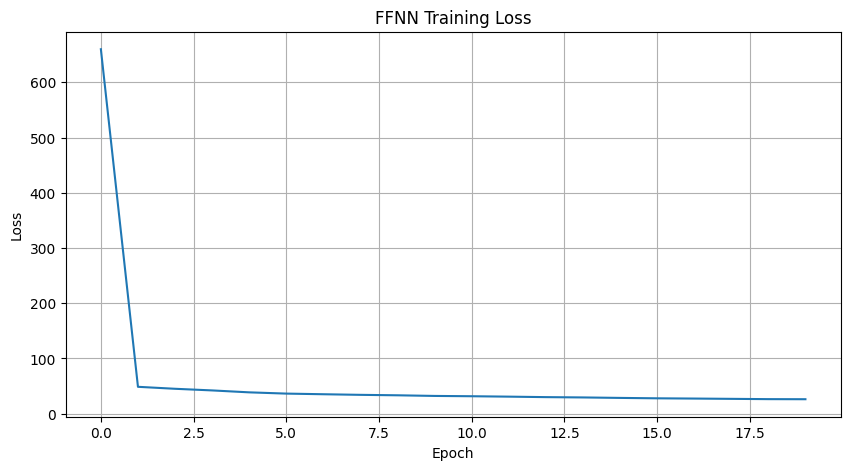

Episode 31/100: Evaluating FFNN
Episode 31/100 | Reward: -957.8397
Train MSE: 26.6085 | Train Female MSE: 7.5003
Val MSE: 99.4221 | Val Female MSE: 7.6810
Test MSE: 55.2826 | Test Female MSE: 3.4146

--------------------------------

Episode 32/100: Generating Synthetic Data
Episode 32/100: Training FFNN


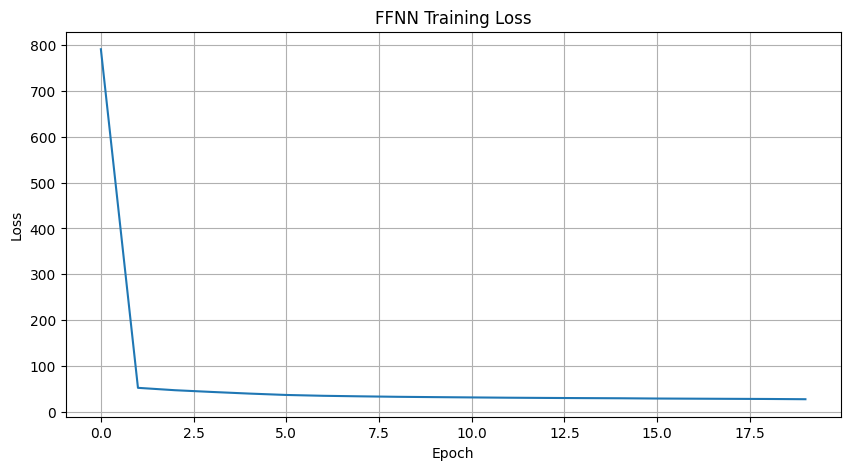

Episode 32/100: Evaluating FFNN
Episode 32/100 | Reward: -760.8350
Train MSE: 26.3814 | Train Female MSE: 4.7670
Val MSE: 79.8153 | Val Female MSE: 12.3292
Test MSE: 60.9771 | Test Female MSE: 5.4186

--------------------------------

Episode 33/100: Generating Synthetic Data
Episode 33/100: Training FFNN


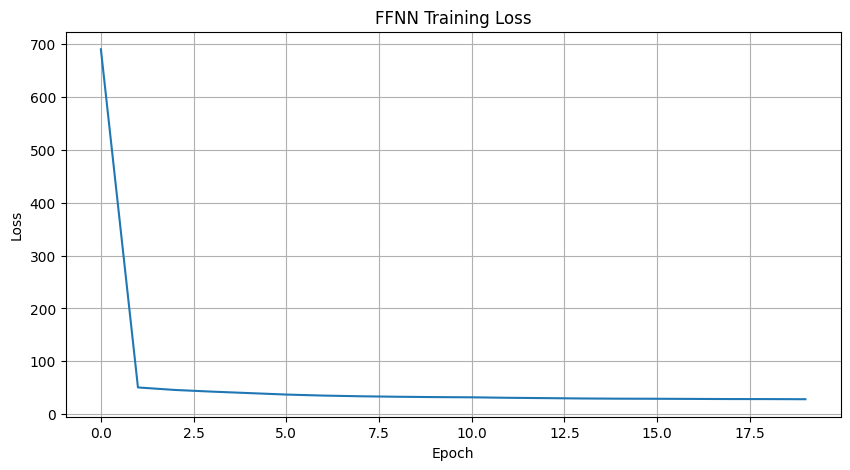

Episode 33/100: Evaluating FFNN
Episode 33/100 | Reward: -1223.0958
Train MSE: 27.3201 | Train Female MSE: 6.3637
Val MSE: 125.8606 | Val Female MSE: 47.4845
Test MSE: 82.0659 | Test Female MSE: 30.5079

--------------------------------

Episode 34/100: Generating Synthetic Data
Episode 34/100: Training FFNN


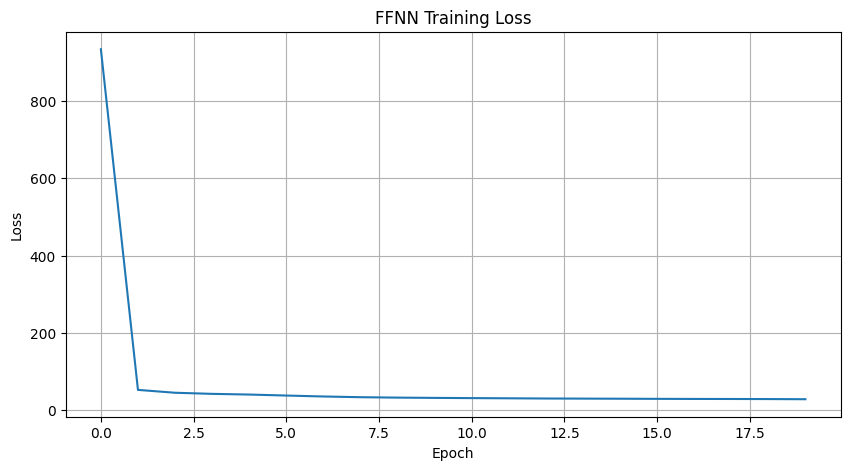

Episode 34/100: Evaluating FFNN
Episode 34/100 | Reward: -2270.9877
Train MSE: 28.3776 | Train Female MSE: 7.7273
Val MSE: 230.7648 | Val Female MSE: 156.5991
Test MSE: 77.9804 | Test Female MSE: 28.6623

--------------------------------

Episode 35/100: Generating Synthetic Data
Episode 35/100: Training FFNN


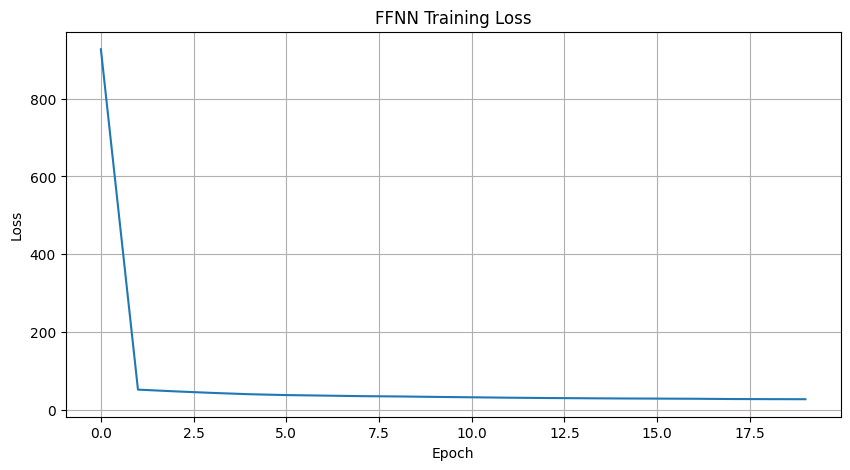

Episode 35/100: Evaluating FFNN
Episode 35/100 | Reward: -1329.0446
Train MSE: 25.9121 | Train Female MSE: 5.9707
Val MSE: 136.7540 | Val Female MSE: 28.8019
Test MSE: 77.2423 | Test Female MSE: 11.4854

--------------------------------

Episode 36/100: Generating Synthetic Data
Episode 36/100: Training FFNN


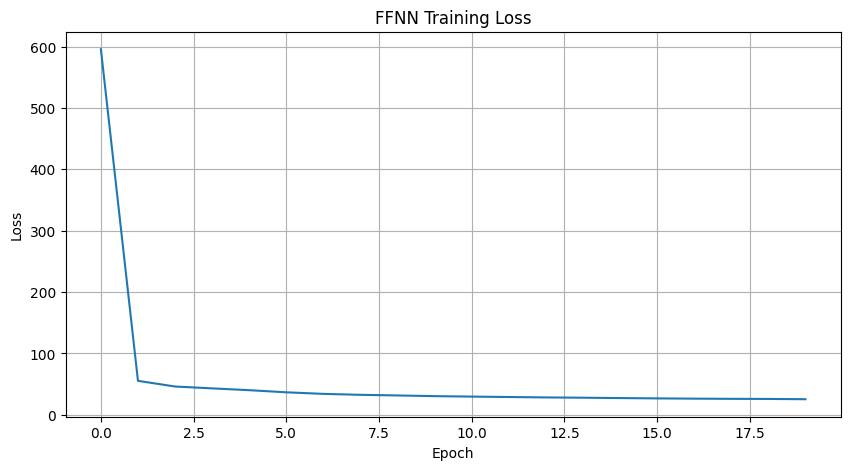

Episode 36/100: Evaluating FFNN
Episode 36/100 | Reward: -717.5395
Train MSE: 24.4347 | Train Female MSE: 6.7716
Val MSE: 76.1403 | Val Female MSE: 9.4773
Test MSE: 54.9851 | Test Female MSE: 4.5674

--------------------------------

Episode 37/100: Generating Synthetic Data
Episode 37/100: Training FFNN


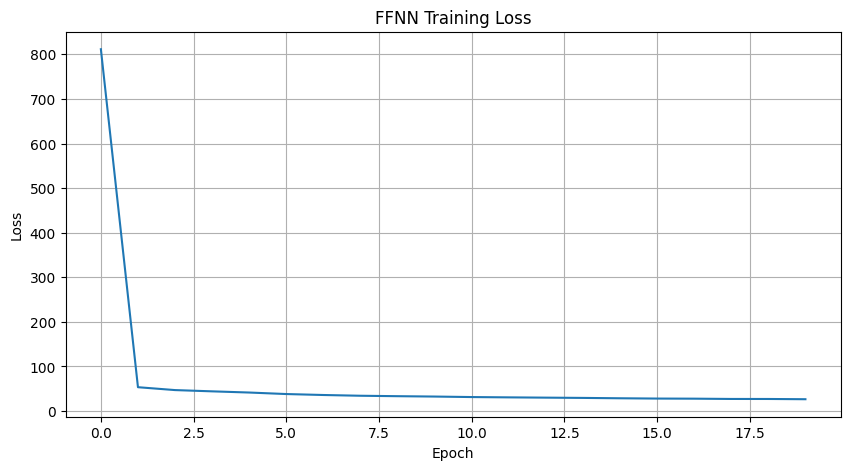

Episode 37/100: Evaluating FFNN
Episode 37/100 | Reward: -968.5733
Train MSE: 25.8229 | Train Female MSE: 7.1739
Val MSE: 102.4330 | Val Female MSE: 42.7891
Test MSE: 71.6583 | Test Female MSE: 31.5267

--------------------------------

Episode 38/100: Generating Synthetic Data
Episode 38/100: Training FFNN


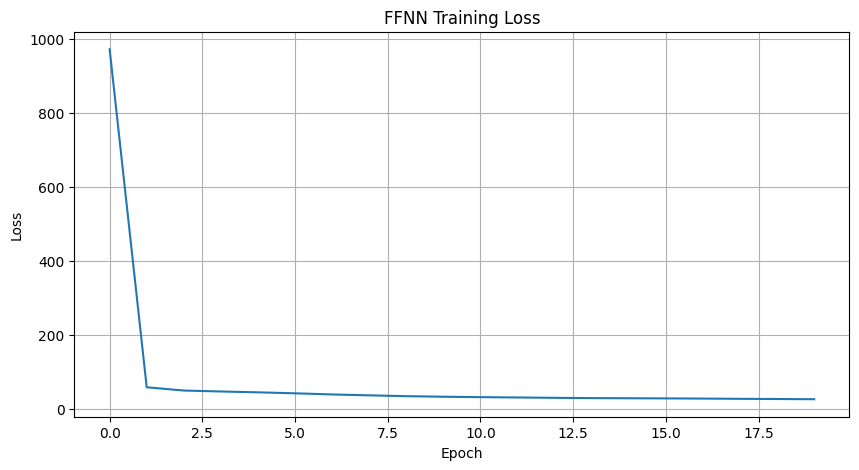

Episode 38/100: Evaluating FFNN
Episode 38/100 | Reward: -727.3324
Train MSE: 25.5398 | Train Female MSE: 5.6555
Val MSE: 78.5084 | Val Female MSE: 17.3490
Test MSE: 94.1804 | Test Female MSE: 25.2974

--------------------------------

Episode 39/100: Generating Synthetic Data
Episode 39/100: Training FFNN


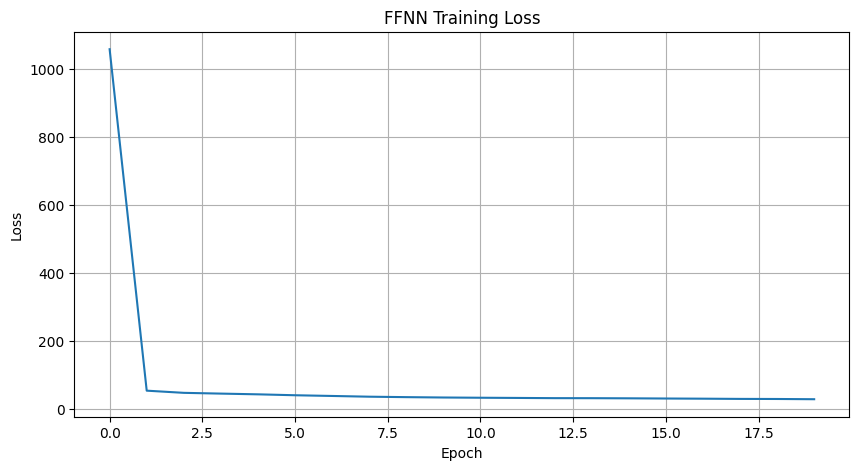

Episode 39/100: Evaluating FFNN
Episode 39/100 | Reward: -1037.9574
Train MSE: 28.5242 | Train Female MSE: 5.1728
Val MSE: 109.8278 | Val Female MSE: 7.7993
Test MSE: 50.4409 | Test Female MSE: 5.1330

--------------------------------

Episode 40/100: Generating Synthetic Data
Episode 40/100: Training FFNN


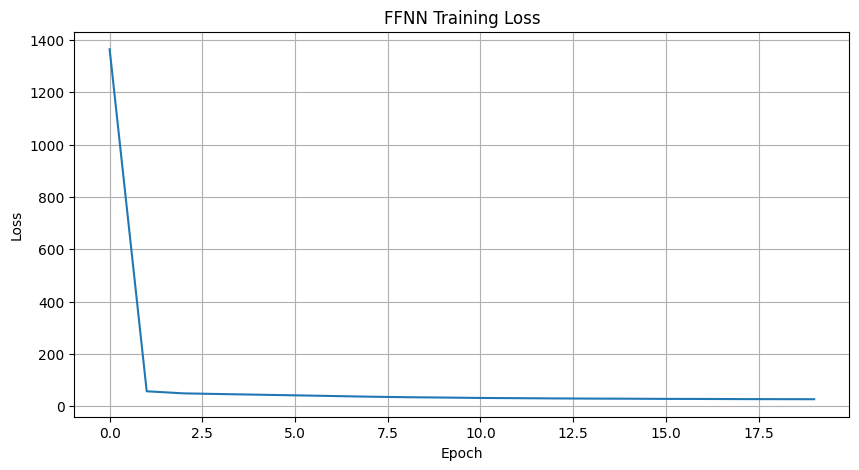

Episode 40/100: Evaluating FFNN
Episode 40/100 | Reward: -932.3804
Train MSE: 26.6382 | Train Female MSE: 7.3812
Val MSE: 99.1968 | Val Female MSE: 7.2072
Test MSE: 90.1807 | Test Female MSE: 52.2549

--------------------------------

Episode 41/100: Generating Synthetic Data
Episode 41/100: Training FFNN


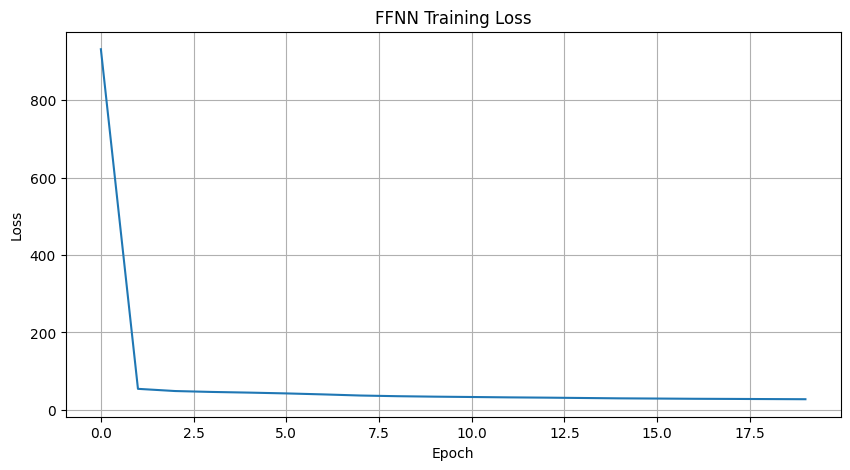

Episode 41/100: Evaluating FFNN
Episode 41/100 | Reward: -1536.4959
Train MSE: 27.3040 | Train Female MSE: 5.8431
Val MSE: 159.3023 | Val Female MSE: 27.6111
Test MSE: 52.7737 | Test Female MSE: 6.1625

--------------------------------

Episode 42/100: Generating Synthetic Data
Episode 42/100: Training FFNN


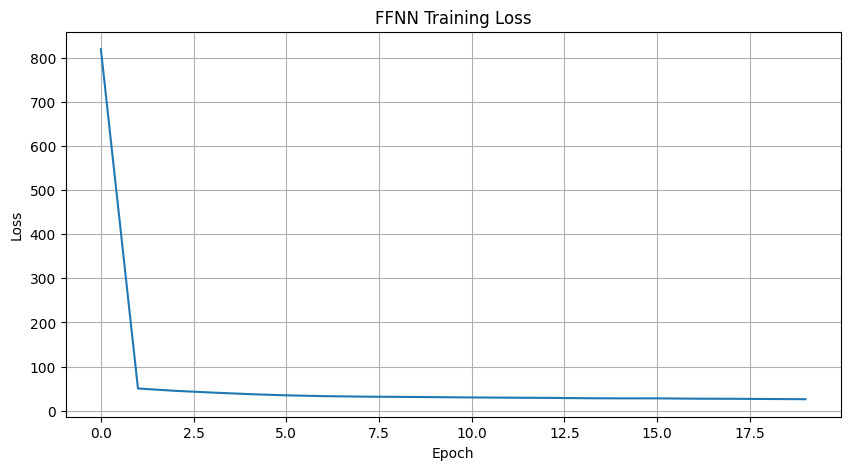

Episode 42/100: Evaluating FFNN
Episode 42/100 | Reward: -822.0414
Train MSE: 26.6137 | Train Female MSE: 6.9083
Val MSE: 87.7485 | Val Female MSE: 25.3549
Test MSE: 61.0227 | Test Female MSE: 7.8850

--------------------------------

Episode 43/100: Generating Synthetic Data
Episode 43/100: Training FFNN


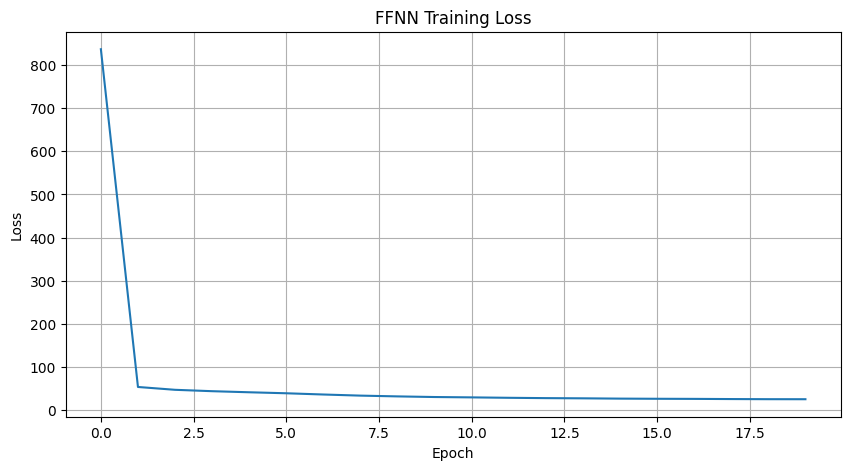

Episode 43/100: Evaluating FFNN
Episode 43/100 | Reward: -983.2557
Train MSE: 26.3256 | Train Female MSE: 6.7029
Val MSE: 103.5342 | Val Female MSE: 43.3314
Test MSE: 74.0917 | Test Female MSE: 36.7700

--------------------------------

Episode 44/100: Generating Synthetic Data
Episode 44/100: Training FFNN


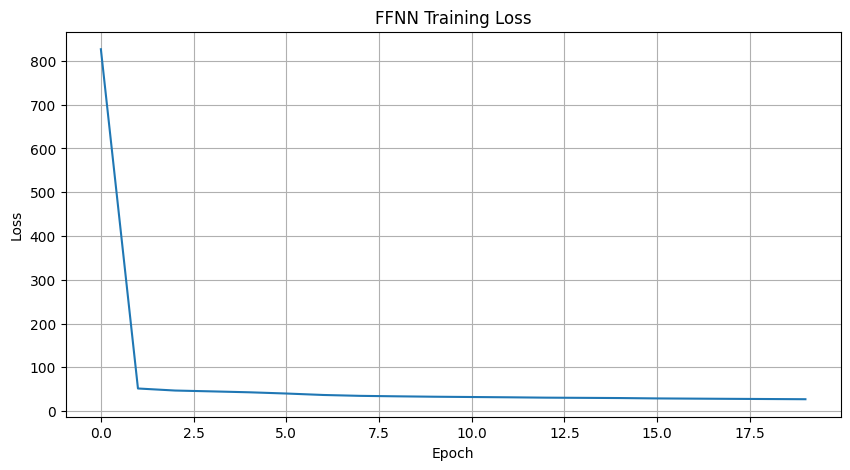

Episode 44/100: Evaluating FFNN
Episode 44/100 | Reward: -669.2616
Train MSE: 27.2303 | Train Female MSE: 6.8952
Val MSE: 72.9041 | Val Female MSE: 6.5969
Test MSE: 78.3751 | Test Female MSE: 31.0664

--------------------------------

Episode 45/100: Generating Synthetic Data
Episode 45/100: Training FFNN


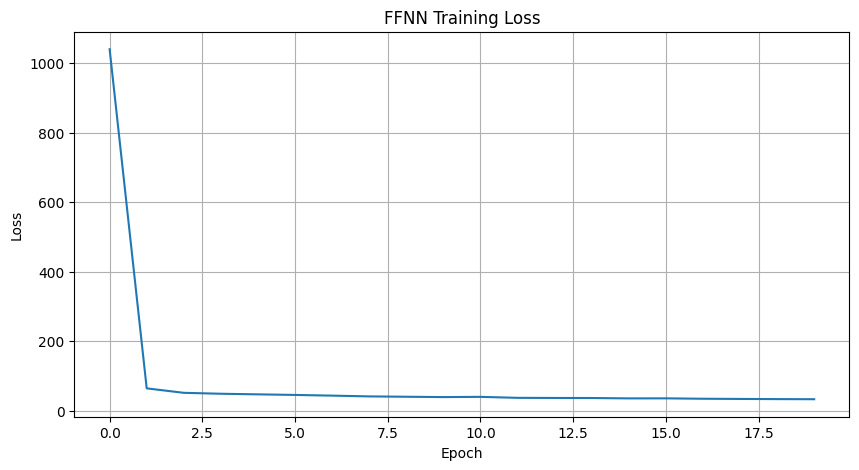

Episode 45/100: Evaluating FFNN
Episode 45/100 | Reward: -1670.7400
Train MSE: 32.4316 | Train Female MSE: 5.9207
Val MSE: 173.1645 | Val Female MSE: 40.8554
Test MSE: 56.2928 | Test Female MSE: 3.1088

--------------------------------

Episode 46/100: Generating Synthetic Data
Episode 46/100: Training FFNN


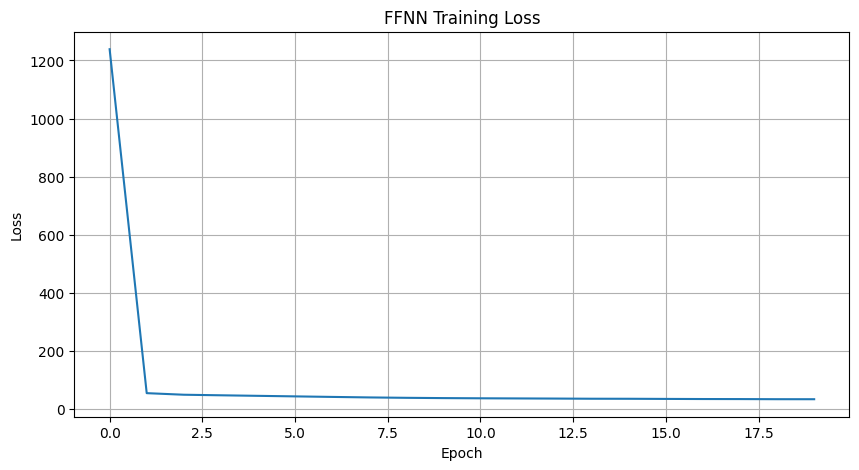

Episode 46/100: Evaluating FFNN
Episode 46/100 | Reward: -1410.0347
Train MSE: 33.6540 | Train Female MSE: 5.9606
Val MSE: 146.9524 | Val Female MSE: 31.8224
Test MSE: 62.0096 | Test Female MSE: 7.4061

--------------------------------

Episode 47/100: Generating Synthetic Data
Episode 47/100: Training FFNN


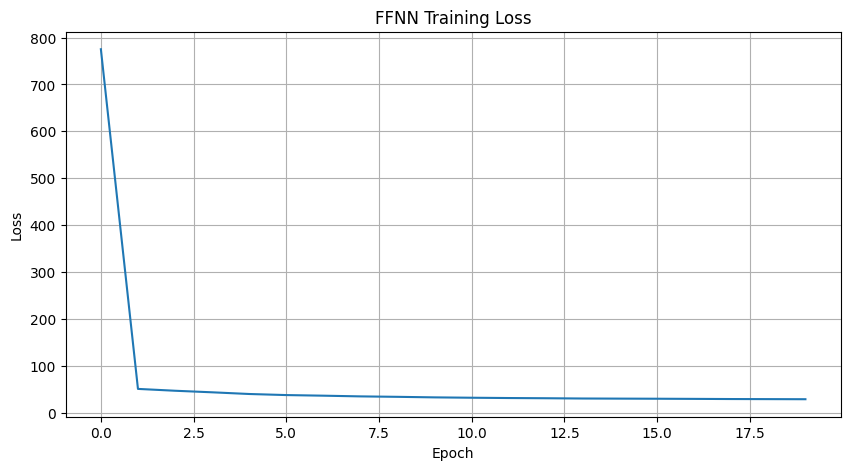

Episode 47/100: Evaluating FFNN
Episode 47/100 | Reward: -3620.6963
Train MSE: 29.9375 | Train Female MSE: 8.3948
Val MSE: 368.4364 | Val Female MSE: 50.0351
Test MSE: 71.6456 | Test Female MSE: 23.7771

--------------------------------

Episode 48/100: Generating Synthetic Data
Episode 48/100: Training FFNN


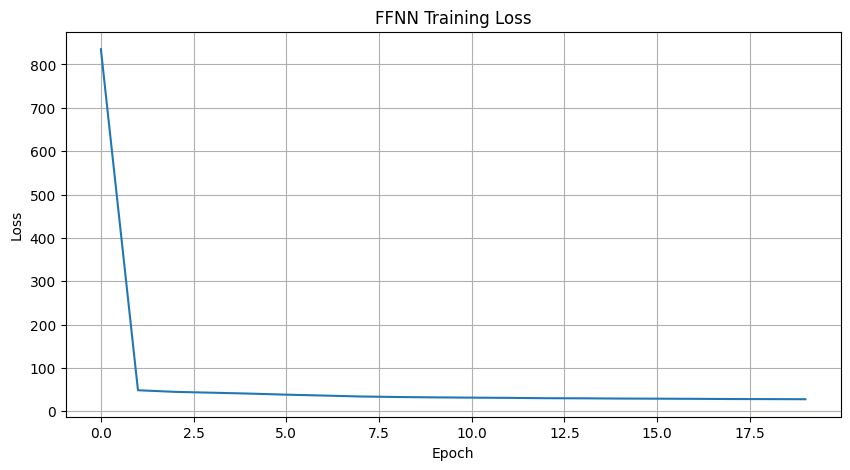

Episode 48/100: Evaluating FFNN
Episode 48/100 | Reward: -903.1815
Train MSE: 28.4508 | Train Female MSE: 7.5674
Val MSE: 95.1597 | Val Female MSE: 6.2384
Test MSE: 75.6969 | Test Female MSE: 24.3638

--------------------------------

Episode 49/100: Generating Synthetic Data
Episode 49/100: Training FFNN


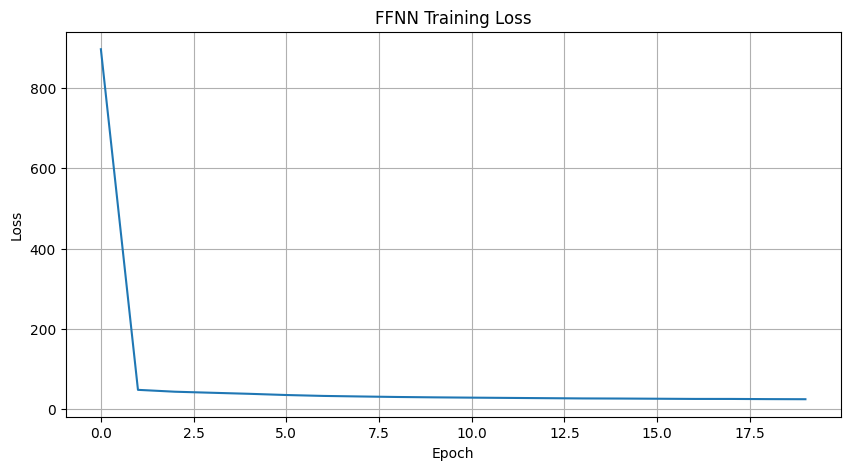

Episode 49/100: Evaluating FFNN
Episode 49/100 | Reward: -3173.1875
Train MSE: 26.3649 | Train Female MSE: 9.1691
Val MSE: 322.3297 | Val Female MSE: 344.4611
Test MSE: 74.1680 | Test Female MSE: 8.7278

--------------------------------

Episode 50/100: Generating Synthetic Data
Episode 50/100: Training FFNN


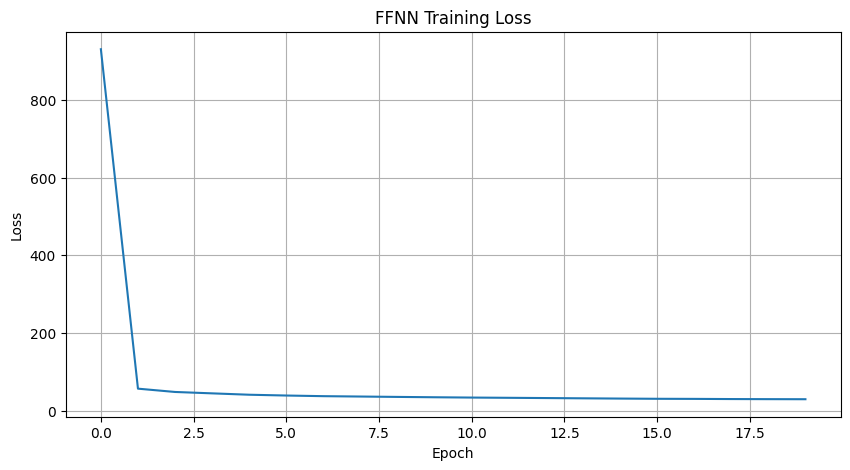

Episode 50/100: Evaluating FFNN
Episode 50/100 | Reward: -2510.2648
Train MSE: 31.8795 | Train Female MSE: 8.9536
Val MSE: 256.7984 | Val Female MSE: 40.2486
Test MSE: 45.2073 | Test Female MSE: 5.5666

--------------------------------

Episode 51/100: Generating Synthetic Data
Episode 51/100: Training FFNN


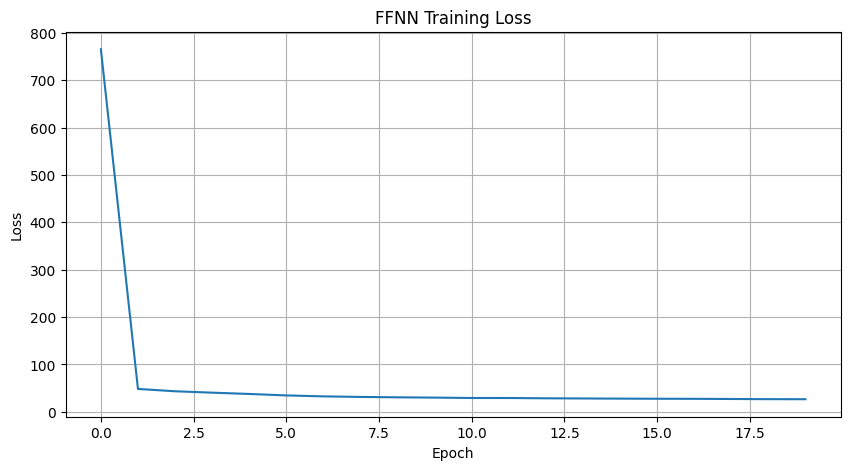

Episode 51/100: Evaluating FFNN
Episode 51/100 | Reward: -903.3111
Train MSE: 27.1633 | Train Female MSE: 4.3624
Val MSE: 97.9632 | Val Female MSE: 34.0546
Test MSE: 90.8680 | Test Female MSE: 28.5178

--------------------------------

Episode 52/100: Generating Synthetic Data
Episode 52/100: Training FFNN


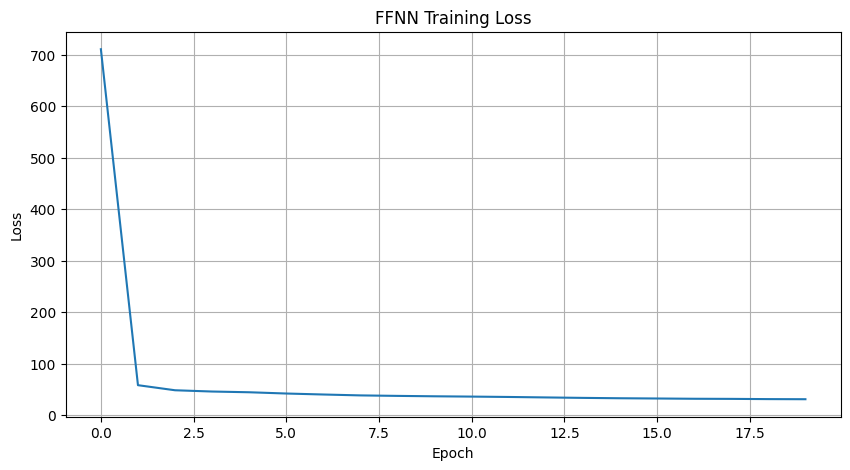

Episode 52/100: Evaluating FFNN
Episode 52/100 | Reward: -630.1702
Train MSE: 30.1162 | Train Female MSE: 6.3991
Val MSE: 70.6242 | Val Female MSE: 7.4760
Test MSE: 50.3310 | Test Female MSE: 11.4029

--------------------------------

Episode 53/100: Generating Synthetic Data
Episode 53/100: Training FFNN


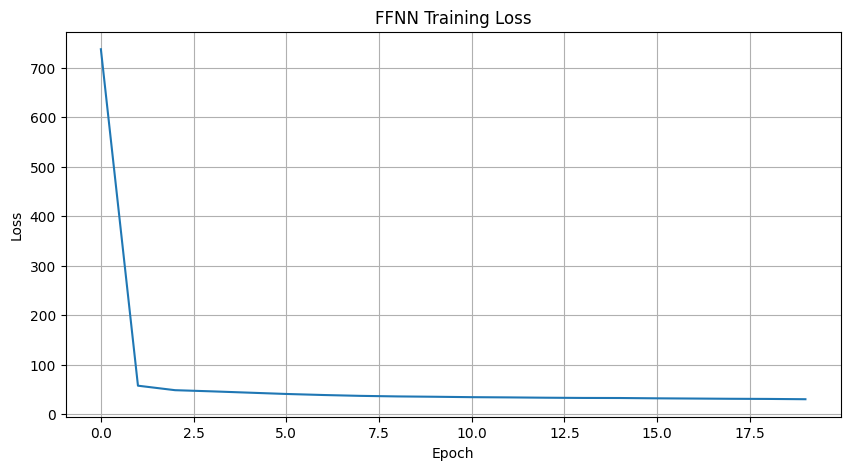

Episode 53/100: Evaluating FFNN
Episode 53/100 | Reward: -1020.2169
Train MSE: 29.2953 | Train Female MSE: 6.1174
Val MSE: 109.9946 | Val Female MSE: 23.7401
Test MSE: 49.2097 | Test Female MSE: 6.1311

--------------------------------

Episode 54/100: Generating Synthetic Data
Episode 54/100: Training FFNN


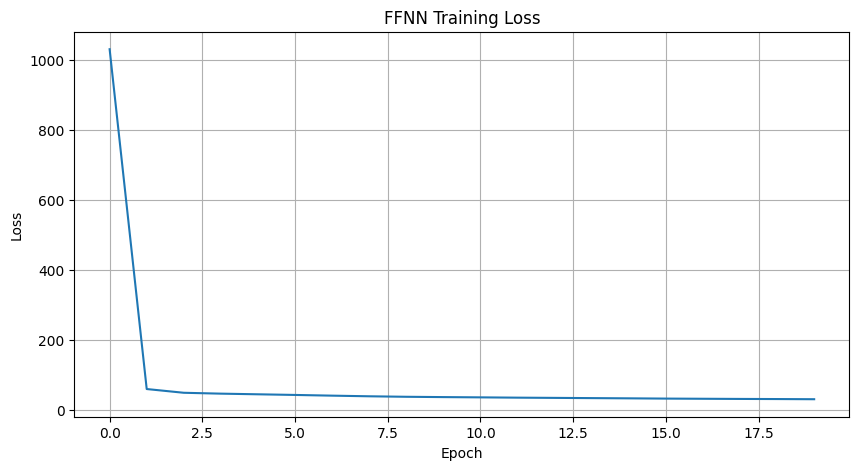

Episode 54/100: Evaluating FFNN
Episode 54/100 | Reward: -1395.3679
Train MSE: 31.3289 | Train Female MSE: 6.3059
Val MSE: 146.4026 | Val Female MSE: 21.7634
Test MSE: 41.2392 | Test Female MSE: 3.4883

--------------------------------

Episode 55/100: Generating Synthetic Data
Episode 55/100: Training FFNN


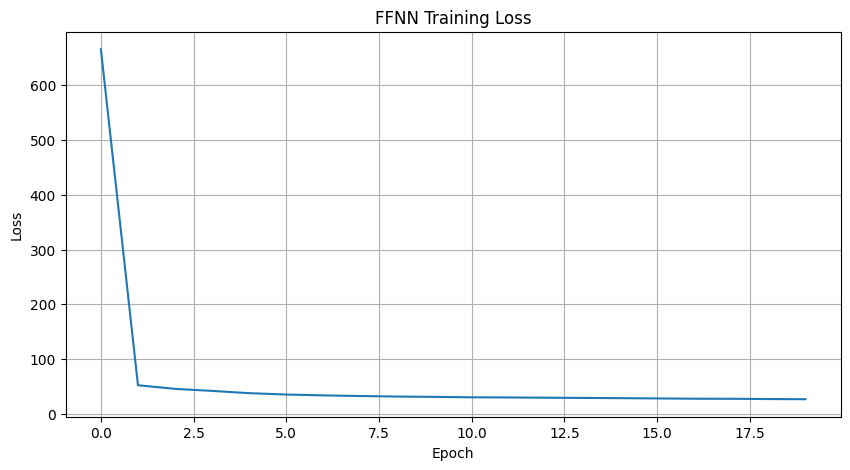

Episode 55/100: Evaluating FFNN
Episode 55/100 | Reward: -1475.4180
Train MSE: 28.2099 | Train Female MSE: 5.7821
Val MSE: 153.3389 | Val Female MSE: 36.0562
Test MSE: 122.4521 | Test Female MSE: 37.3203

--------------------------------

Episode 56/100: Generating Synthetic Data
Episode 56/100: Training FFNN


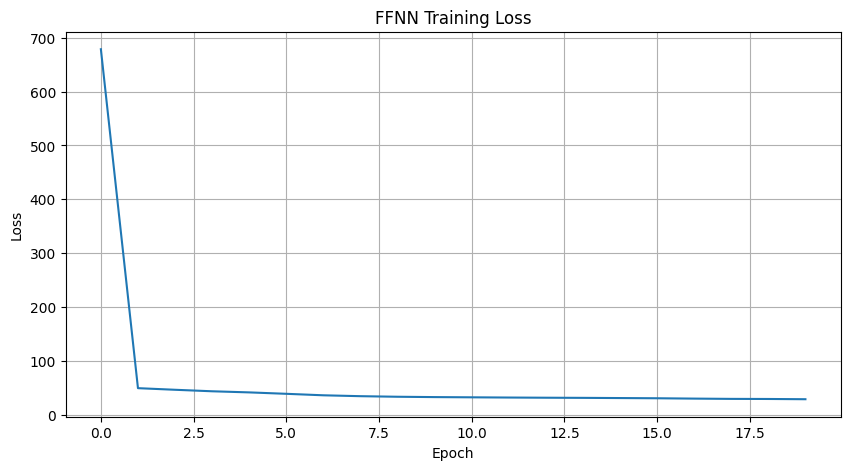

Episode 56/100: Evaluating FFNN
Episode 56/100 | Reward: -1676.6590
Train MSE: 31.6582 | Train Female MSE: 8.4615
Val MSE: 173.4019 | Val Female MSE: 97.9886
Test MSE: 73.8809 | Test Female MSE: 25.9629

--------------------------------

Episode 57/100: Generating Synthetic Data
Episode 57/100: Training FFNN


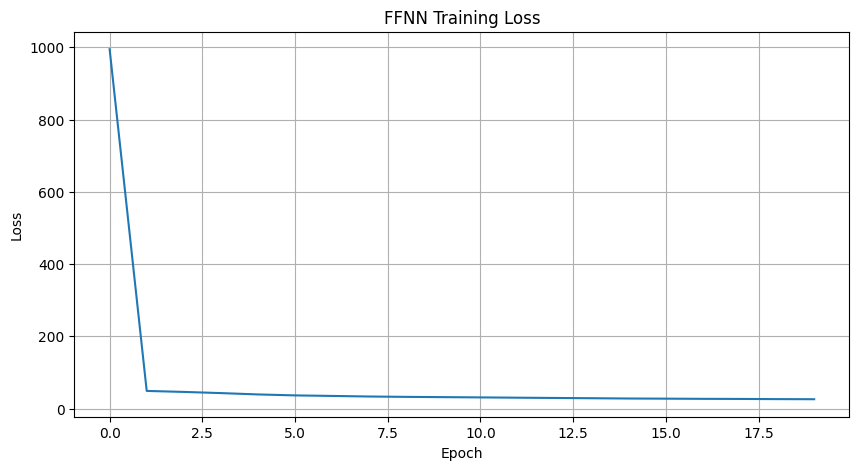

Episode 57/100: Evaluating FFNN
Episode 57/100 | Reward: -1235.9340
Train MSE: 26.8538 | Train Female MSE: 7.7825
Val MSE: 127.0988 | Val Female MSE: 20.2606
Test MSE: 86.4385 | Test Female MSE: 43.3964

--------------------------------

Episode 58/100: Generating Synthetic Data
Episode 58/100: Training FFNN


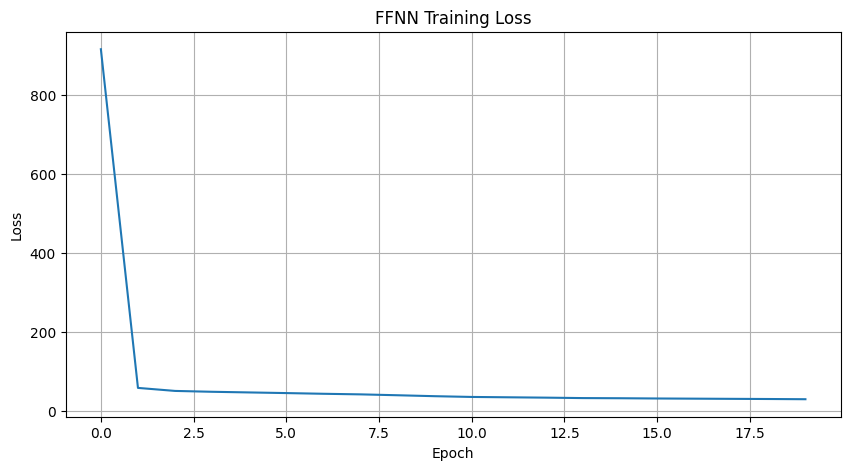

Episode 58/100: Evaluating FFNN
Episode 58/100 | Reward: -970.5454
Train MSE: 28.2364 | Train Female MSE: 7.4213
Val MSE: 100.7206 | Val Female MSE: 14.8394
Test MSE: 55.6095 | Test Female MSE: 9.4691

--------------------------------

Episode 59/100: Generating Synthetic Data
Episode 59/100: Training FFNN


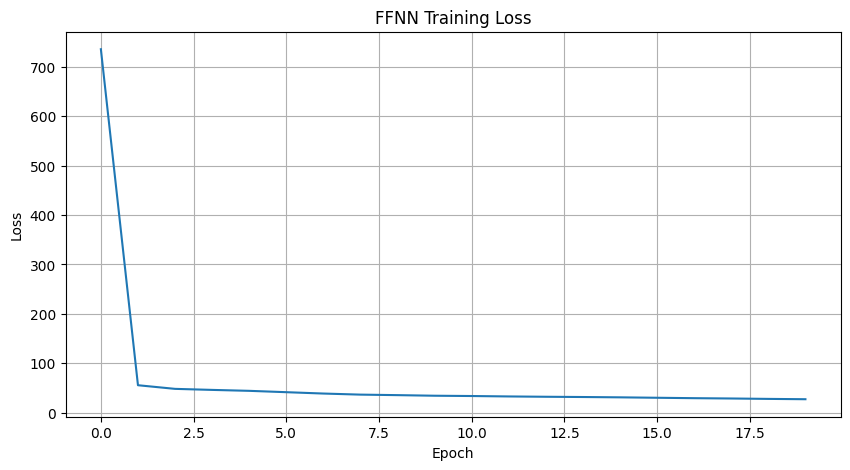

Episode 59/100: Evaluating FFNN
Episode 59/100 | Reward: -2155.5506
Train MSE: 27.2310 | Train Female MSE: 5.7033
Val MSE: 219.0933 | Val Female MSE: 34.7964
Test MSE: 69.5917 | Test Female MSE: 4.6875

--------------------------------

Episode 60/100: Generating Synthetic Data
Episode 60/100: Training FFNN


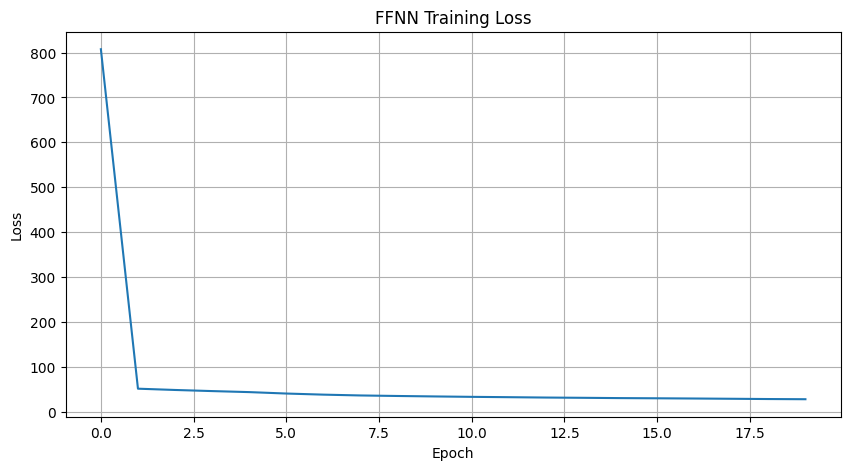

Episode 60/100: Evaluating FFNN
Episode 60/100 | Reward: -1878.2943
Train MSE: 28.5489 | Train Female MSE: 6.9532
Val MSE: 191.1086 | Val Female MSE: 53.9893
Test MSE: 66.0896 | Test Female MSE: 8.9435

--------------------------------

Episode 61/100: Generating Synthetic Data
Episode 61/100: Training FFNN


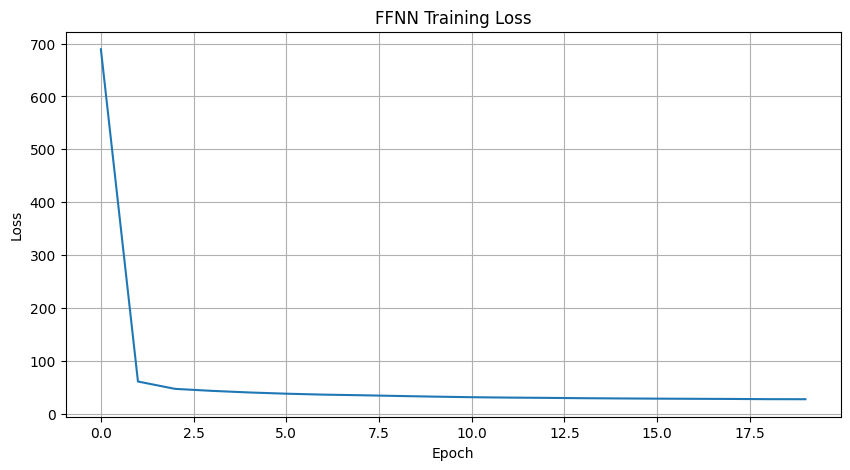

Episode 61/100: Evaluating FFNN
Episode 61/100 | Reward: -2189.2719
Train MSE: 26.9674 | Train Female MSE: 5.8666
Val MSE: 222.6911 | Val Female MSE: 132.8923
Test MSE: 64.6129 | Test Female MSE: 13.3667

--------------------------------

Episode 62/100: Generating Synthetic Data
Episode 62/100: Training FFNN


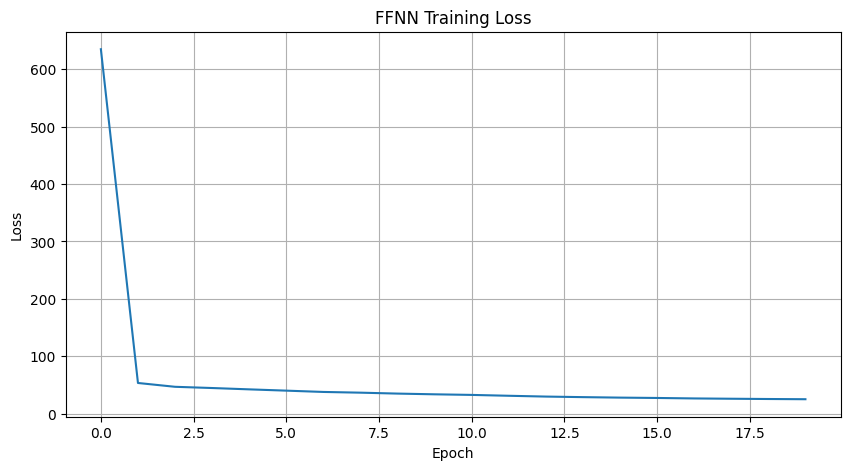

Episode 62/100: Evaluating FFNN
Episode 62/100 | Reward: -1192.1195
Train MSE: 24.0363 | Train Female MSE: 3.8838
Val MSE: 122.8417 | Val Female MSE: 13.1682
Test MSE: 60.4479 | Test Female MSE: 12.5739

--------------------------------

Episode 63/100: Generating Synthetic Data
Episode 63/100: Training FFNN


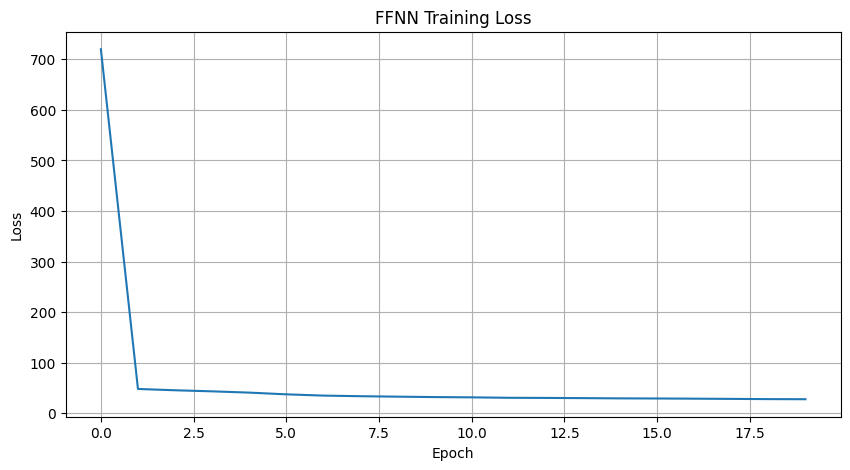

Episode 63/100: Evaluating FFNN
Episode 63/100 | Reward: -1514.1773
Train MSE: 27.2630 | Train Female MSE: 5.2532
Val MSE: 154.9555 | Val Female MSE: 45.4885
Test MSE: 55.4131 | Test Female MSE: 3.4789

--------------------------------

Episode 64/100: Generating Synthetic Data
Episode 64/100: Training FFNN


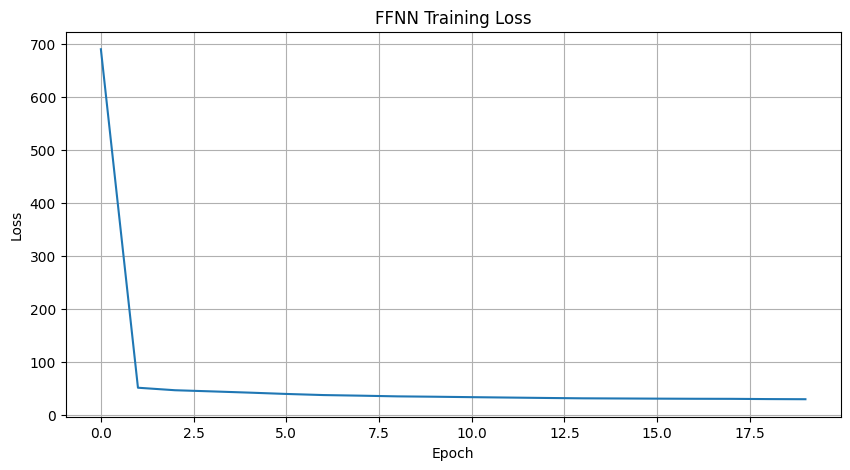

Episode 64/100: Evaluating FFNN
Episode 64/100 | Reward: -1061.6473
Train MSE: 29.3689 | Train Female MSE: 7.5296
Val MSE: 109.7122 | Val Female MSE: 39.9981
Test MSE: 63.2949 | Test Female MSE: 32.0896

--------------------------------

Episode 65/100: Generating Synthetic Data
Episode 65/100: Training FFNN


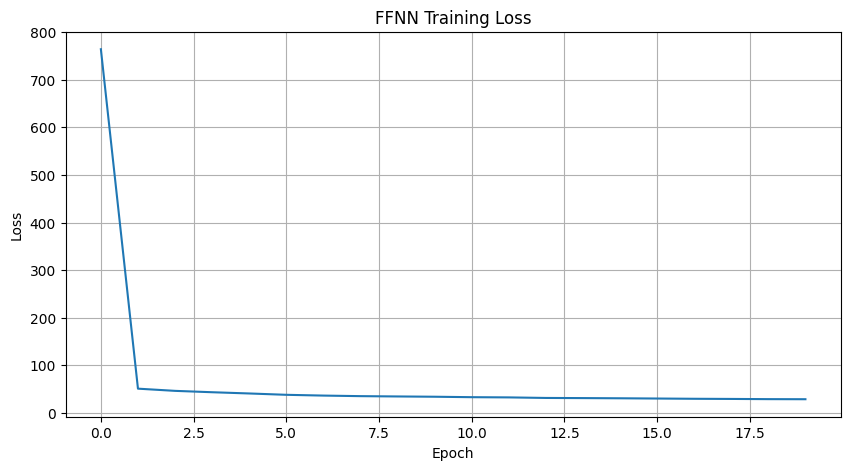

Episode 65/100: Evaluating FFNN
Episode 65/100 | Reward: -1508.5749
Train MSE: 29.6834 | Train Female MSE: 8.5110
Val MSE: 154.3335 | Val Female MSE: 47.7905
Test MSE: 64.2514 | Test Female MSE: 15.7119

--------------------------------

Episode 66/100: Generating Synthetic Data
Episode 66/100: Training FFNN


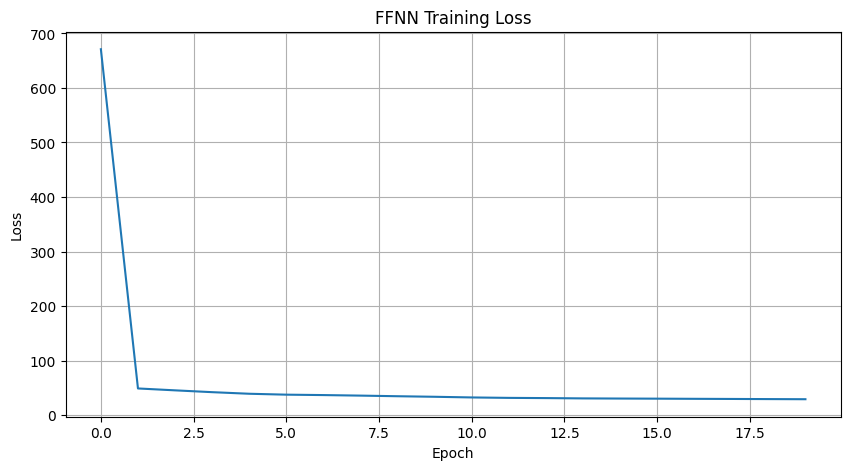

Episode 66/100: Evaluating FFNN
Episode 66/100 | Reward: -1512.7162
Train MSE: 28.3263 | Train Female MSE: 4.9944
Val MSE: 154.4756 | Val Female MSE: 54.1778
Test MSE: 63.7760 | Test Female MSE: 5.5319

--------------------------------

Episode 67/100: Generating Synthetic Data
Episode 67/100: Training FFNN


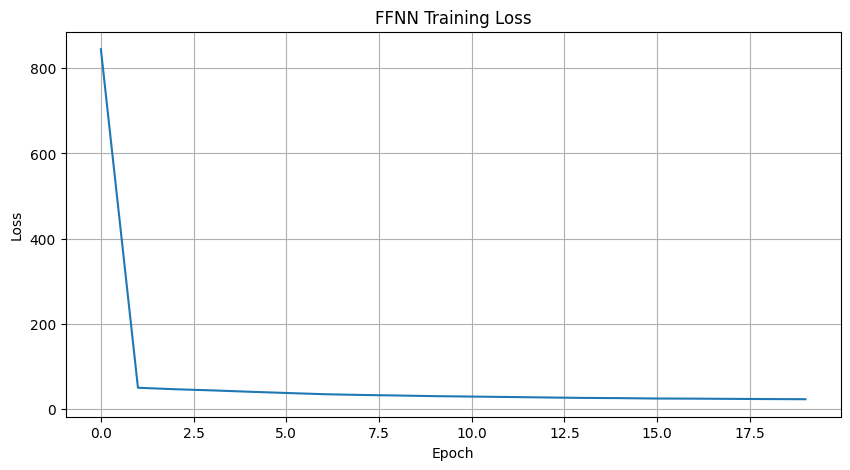

Episode 67/100: Evaluating FFNN
Episode 67/100 | Reward: -1674.7796
Train MSE: 25.0490 | Train Female MSE: 7.1641
Val MSE: 170.8636 | Val Female MSE: 221.8241
Test MSE: 67.6215 | Test Female MSE: 1.4946

--------------------------------

Episode 68/100: Generating Synthetic Data
Episode 68/100: Training FFNN


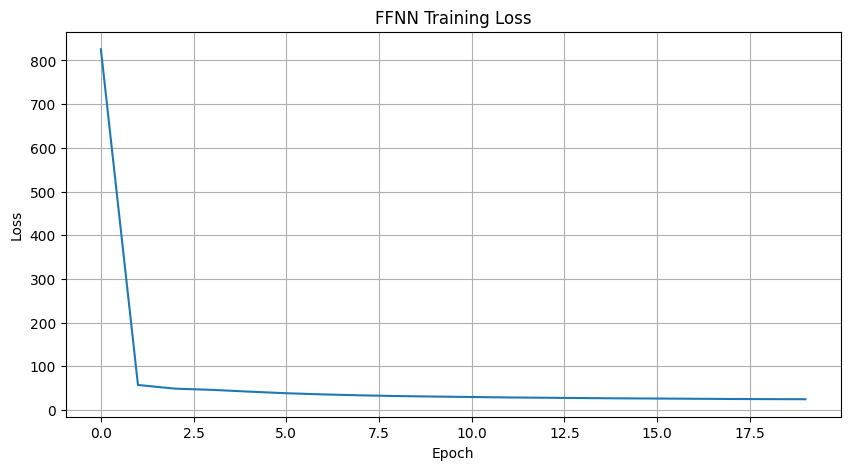

Episode 68/100: Evaluating FFNN
Episode 68/100 | Reward: -2068.4719
Train MSE: 24.4383 | Train Female MSE: 5.1391
Val MSE: 210.3312 | Val Female MSE: 68.6395
Test MSE: 76.7818 | Test Female MSE: 5.5738

--------------------------------

Episode 69/100: Generating Synthetic Data
Episode 69/100: Training FFNN


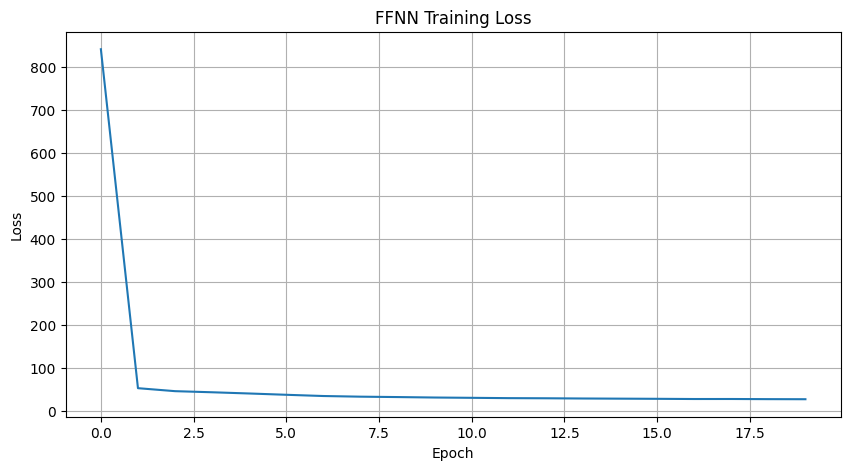

Episode 69/100: Evaluating FFNN
Episode 69/100 | Reward: -3017.6254
Train MSE: 29.2025 | Train Female MSE: 8.5704
Val MSE: 305.1113 | Val Female MSE: 138.2554
Test MSE: 81.1951 | Test Female MSE: 50.5495

--------------------------------

Episode 70/100: Generating Synthetic Data
Episode 70/100: Training FFNN


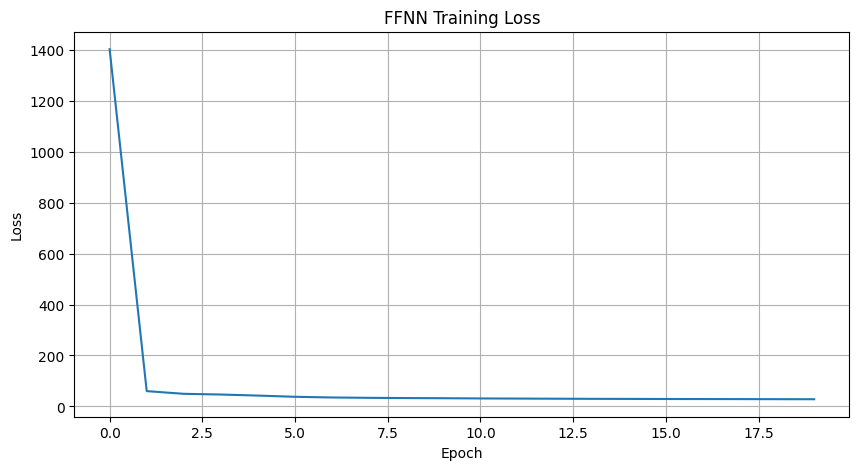

Episode 70/100: Evaluating FFNN
Episode 70/100 | Reward: -2424.3440
Train MSE: 27.8542 | Train Female MSE: 7.1742
Val MSE: 247.0902 | Val Female MSE: 77.5737
Test MSE: 46.0690 | Test Female MSE: 11.6456

--------------------------------

Episode 71/100: Generating Synthetic Data
Episode 71/100: Training FFNN


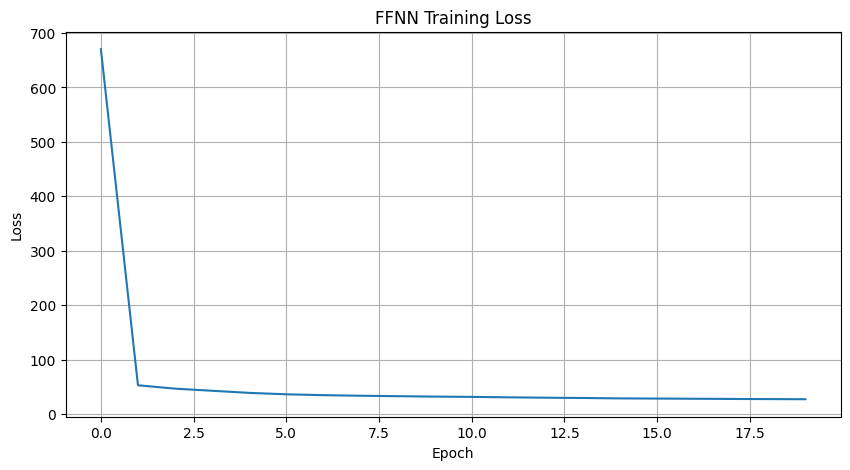

Episode 71/100: Evaluating FFNN
Episode 71/100 | Reward: -731.3131
Train MSE: 27.9205 | Train Female MSE: 8.8260
Val MSE: 77.5030 | Val Female MSE: 32.3719
Test MSE: 37.8363 | Test Female MSE: 9.8971

--------------------------------

Episode 72/100: Generating Synthetic Data
Episode 72/100: Training FFNN


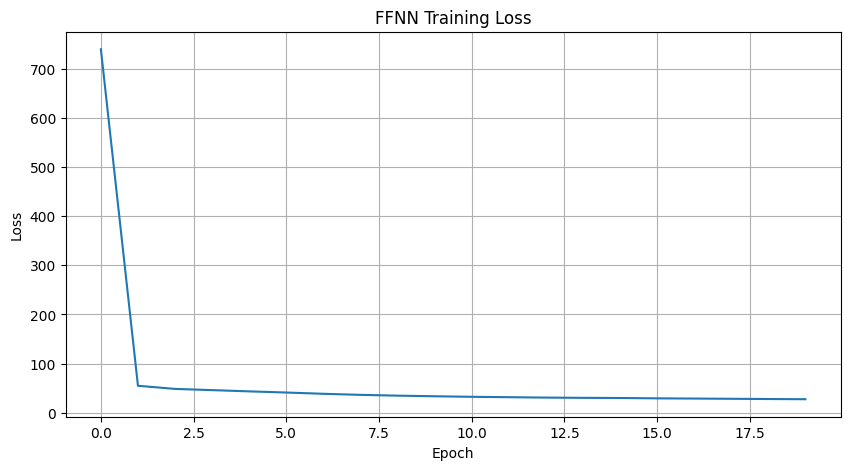

Episode 72/100: Evaluating FFNN
Episode 72/100 | Reward: -1854.8950
Train MSE: 26.7061 | Train Female MSE: 6.1375
Val MSE: 189.8031 | Val Female MSE: 80.6372
Test MSE: 58.9279 | Test Female MSE: 22.5325

--------------------------------

Episode 73/100: Generating Synthetic Data
Episode 73/100: Training FFNN


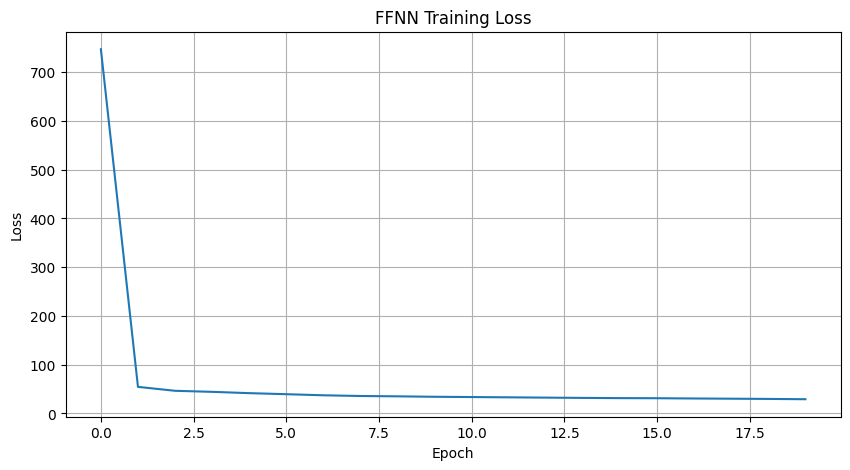

Episode 73/100: Evaluating FFNN
Episode 73/100 | Reward: -1486.3538
Train MSE: 28.6235 | Train Female MSE: 6.1322
Val MSE: 152.9313 | Val Female MSE: 40.7964
Test MSE: 55.5923 | Test Female MSE: 9.6873

--------------------------------

Episode 74/100: Generating Synthetic Data
Episode 74/100: Training FFNN


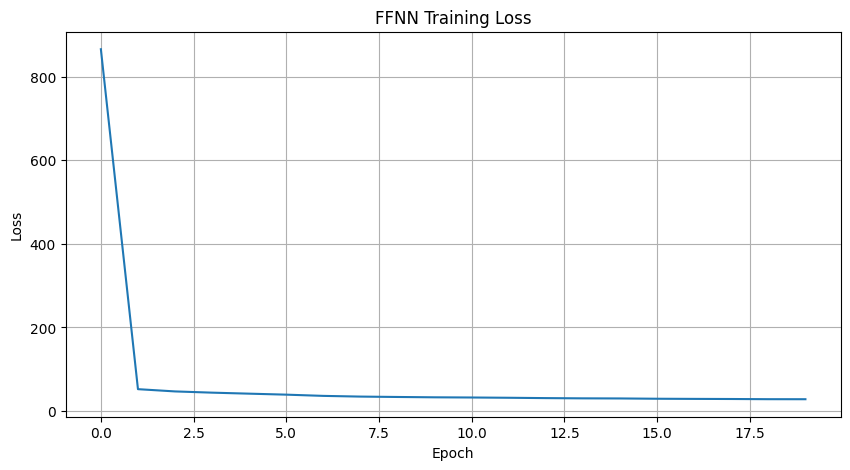

Episode 74/100: Evaluating FFNN
Episode 74/100 | Reward: -720.1785
Train MSE: 30.5229 | Train Female MSE: 9.5795
Val MSE: 76.9671 | Val Female MSE: 14.8477
Test MSE: 66.7615 | Test Female MSE: 2.7082

--------------------------------

Episode 75/100: Generating Synthetic Data
Episode 75/100: Training FFNN


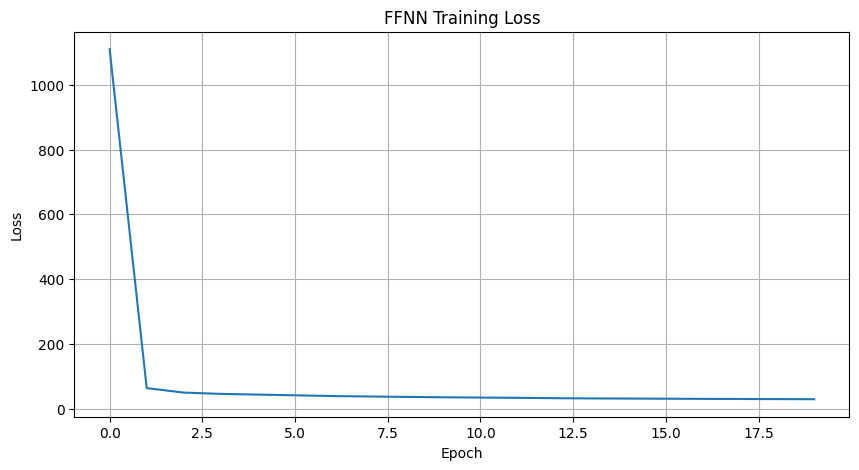

Episode 75/100: Evaluating FFNN
Episode 75/100 | Reward: -1044.7367
Train MSE: 29.9148 | Train Female MSE: 7.4131
Val MSE: 109.3843 | Val Female MSE: 15.2761
Test MSE: 58.2430 | Test Female MSE: 17.6214

--------------------------------

Episode 76/100: Generating Synthetic Data
Episode 76/100: Training FFNN


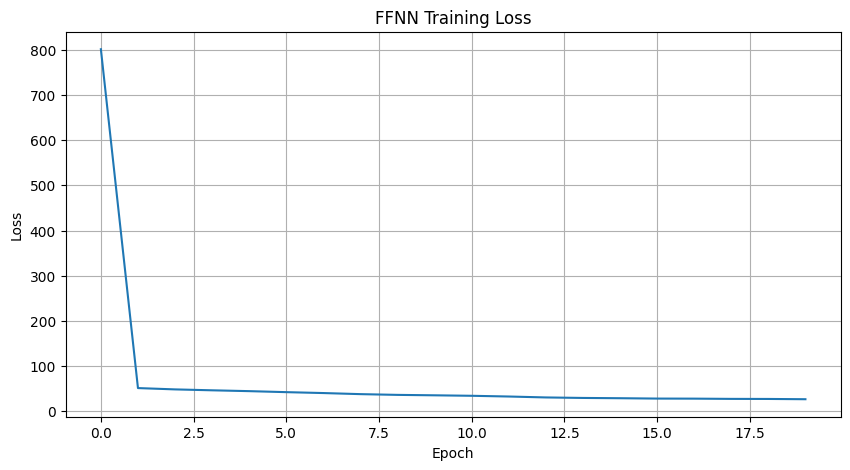

Episode 76/100: Evaluating FFNN
Episode 76/100 | Reward: -1039.3301
Train MSE: 26.9219 | Train Female MSE: 7.3048
Val MSE: 109.3558 | Val Female MSE: 59.9880
Test MSE: 93.4560 | Test Female MSE: 24.3183

--------------------------------

Episode 77/100: Generating Synthetic Data
Episode 77/100: Training FFNN


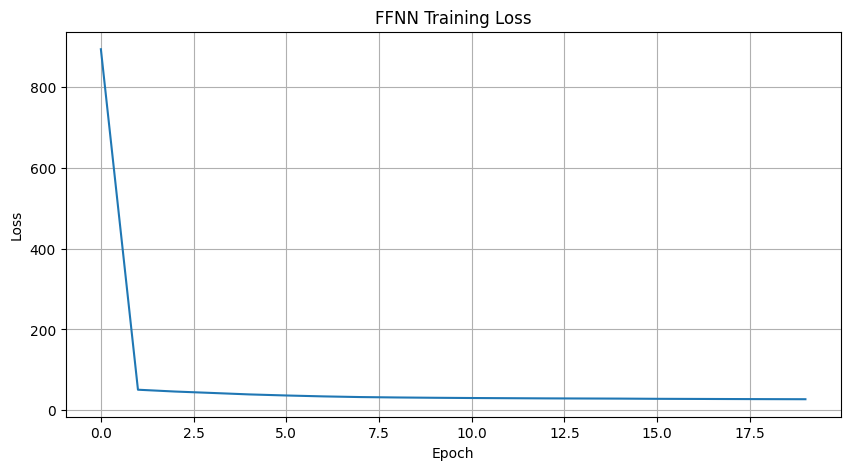

Episode 77/100: Evaluating FFNN
Episode 77/100 | Reward: -779.1752
Train MSE: 26.4079 | Train Female MSE: 7.7439
Val MSE: 82.3300 | Val Female MSE: 25.5851
Test MSE: 47.3226 | Test Female MSE: 9.5091

--------------------------------

Episode 78/100: Generating Synthetic Data
Episode 78/100: Training FFNN


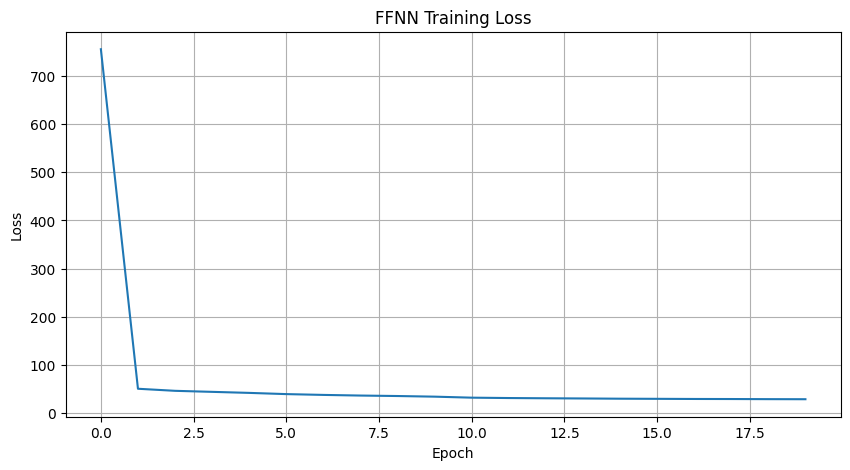

Episode 78/100: Evaluating FFNN
Episode 78/100 | Reward: -2585.5936
Train MSE: 28.9058 | Train Female MSE: 7.1337
Val MSE: 262.9837 | Val Female MSE: 181.1272
Test MSE: 67.6197 | Test Female MSE: 29.0502

--------------------------------

Episode 79/100: Generating Synthetic Data
Episode 79/100: Training FFNN


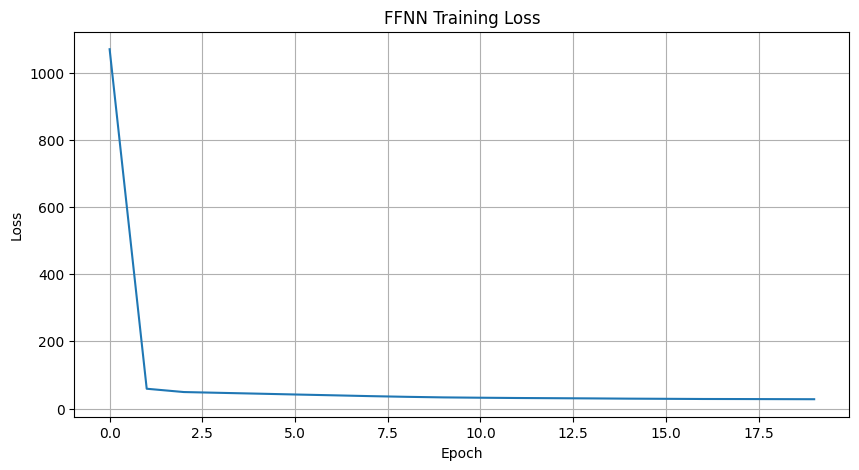

Episode 79/100: Evaluating FFNN
Episode 79/100 | Reward: -1065.6153
Train MSE: 27.0924 | Train Female MSE: 6.3481
Val MSE: 110.6762 | Val Female MSE: 19.0389
Test MSE: 48.7054 | Test Female MSE: 2.2002

--------------------------------

Episode 80/100: Generating Synthetic Data
Episode 80/100: Training FFNN


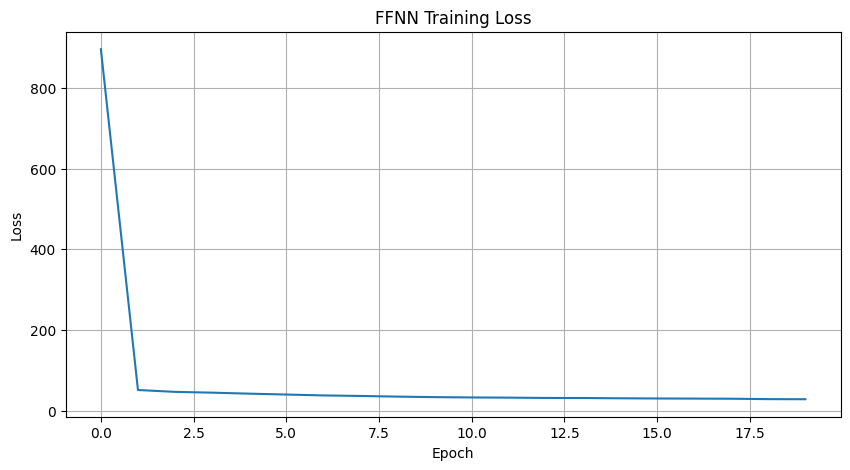

Episode 80/100: Evaluating FFNN
Episode 80/100 | Reward: -1206.0709
Train MSE: 28.4453 | Train Female MSE: 6.8029
Val MSE: 124.8566 | Val Female MSE: 5.3290
Test MSE: 56.9556 | Test Female MSE: 3.4354

--------------------------------

Episode 81/100: Generating Synthetic Data
Episode 81/100: Training FFNN


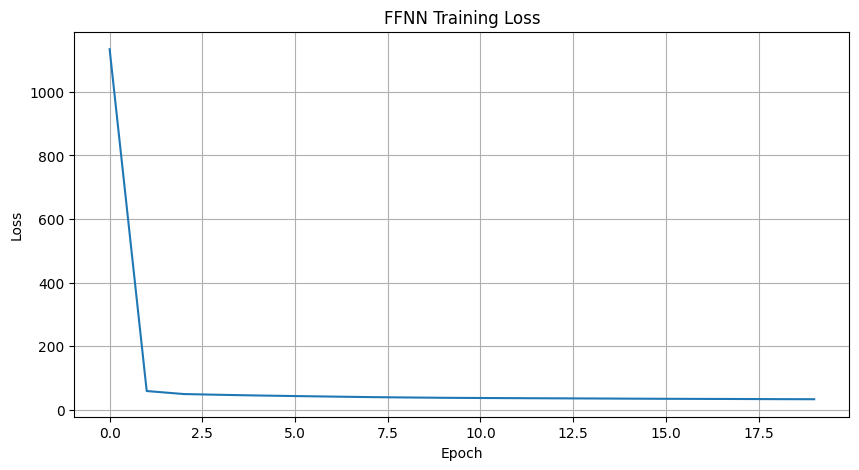

Episode 81/100: Evaluating FFNN
Episode 81/100 | Reward: -1562.0281
Train MSE: 35.1059 | Train Female MSE: 7.6202
Val MSE: 160.4619 | Val Female MSE: 17.5503
Test MSE: 58.3011 | Test Female MSE: 5.4740

--------------------------------

Episode 82/100: Generating Synthetic Data
Episode 82/100: Training FFNN


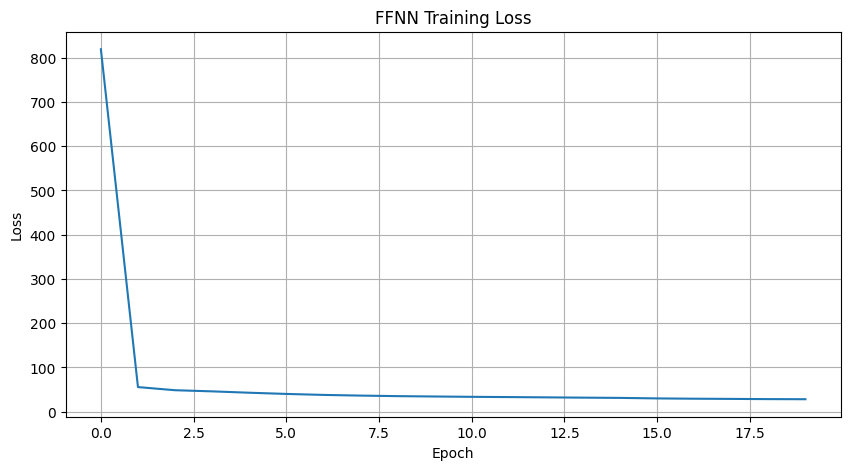

Episode 82/100: Evaluating FFNN
Episode 82/100 | Reward: -1472.6601
Train MSE: 27.7950 | Train Female MSE: 6.0635
Val MSE: 151.6141 | Val Female MSE: 26.8056
Test MSE: 65.3473 | Test Female MSE: 5.7059

--------------------------------

Episode 83/100: Generating Synthetic Data
Episode 83/100: Training FFNN


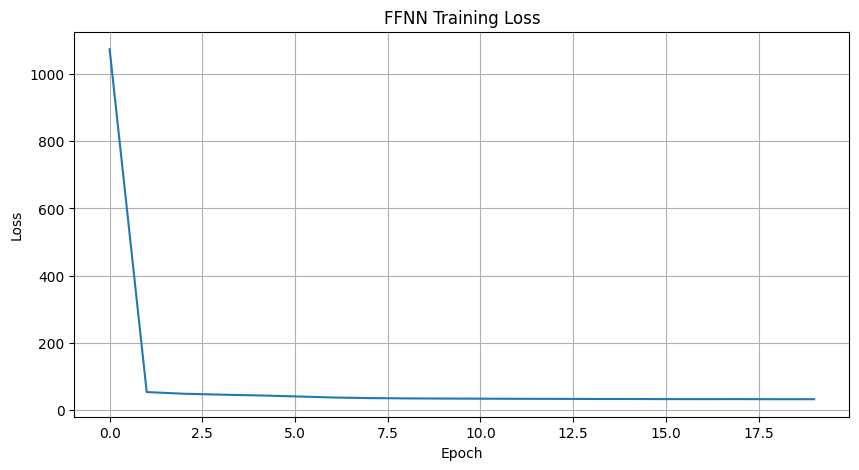

Episode 83/100: Evaluating FFNN
Episode 83/100 | Reward: -852.1114
Train MSE: 31.3242 | Train Female MSE: 8.1027
Val MSE: 89.0753 | Val Female MSE: 18.9292
Test MSE: 57.8178 | Test Female MSE: 24.6917

--------------------------------

Episode 84/100: Generating Synthetic Data
Episode 84/100: Training FFNN


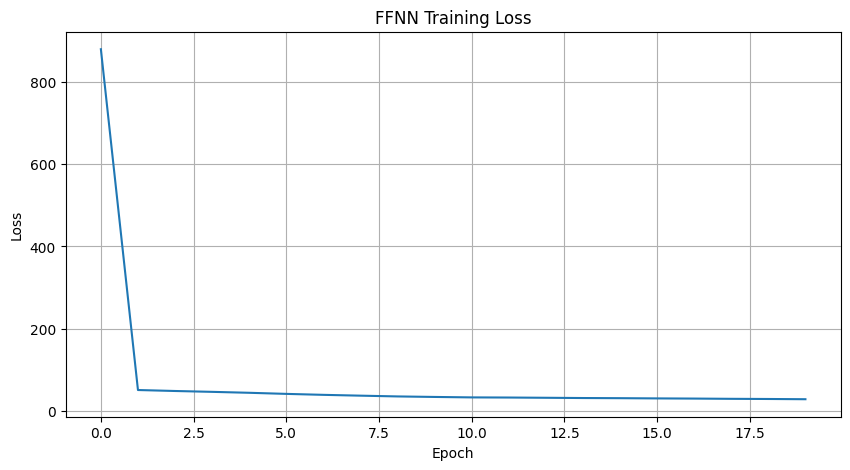

Episode 84/100: Evaluating FFNN
Episode 84/100 | Reward: -1886.6132
Train MSE: 27.6090 | Train Female MSE: 6.8829
Val MSE: 192.2029 | Val Female MSE: 79.4802
Test MSE: 49.5471 | Test Female MSE: 28.7046

--------------------------------

Episode 85/100: Generating Synthetic Data
Episode 85/100: Training FFNN


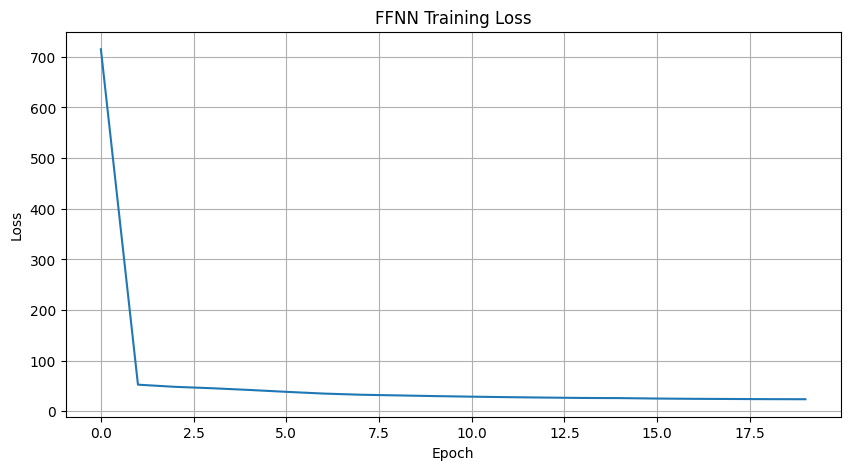

Episode 85/100: Evaluating FFNN
Episode 85/100 | Reward: -1318.2671
Train MSE: 23.6132 | Train Female MSE: 5.1526
Val MSE: 135.5938 | Val Female MSE: 41.1784
Test MSE: 50.1738 | Test Female MSE: 3.5334

--------------------------------

Episode 86/100: Generating Synthetic Data
Episode 86/100: Training FFNN


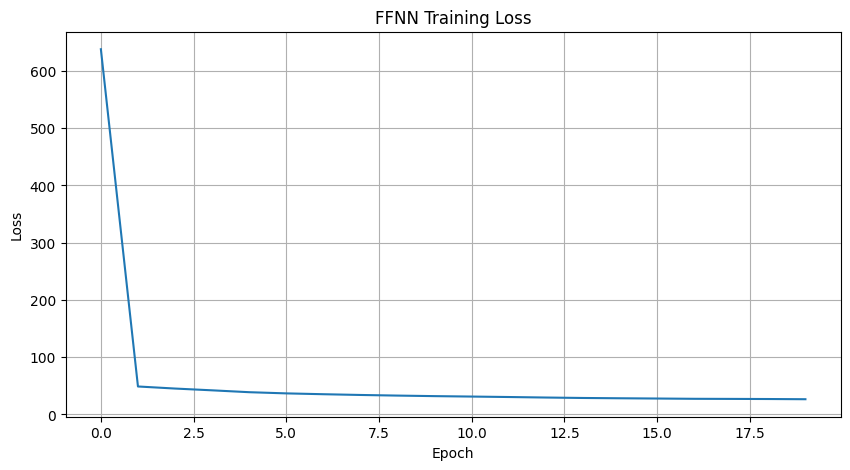

Episode 86/100: Evaluating FFNN
Episode 86/100 | Reward: -867.8237
Train MSE: 25.6526 | Train Female MSE: 5.9370
Val MSE: 90.4170 | Val Female MSE: 14.1033
Test MSE: 45.3243 | Test Female MSE: 9.0225

--------------------------------

Episode 87/100: Generating Synthetic Data
Episode 87/100: Training FFNN


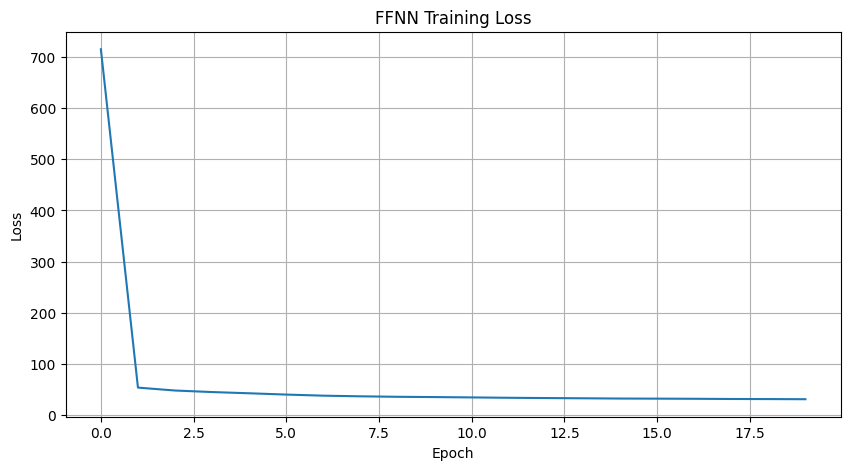

Episode 87/100: Evaluating FFNN
Episode 87/100 | Reward: -2136.6239
Train MSE: 29.4708 | Train Female MSE: 7.3609
Val MSE: 218.3601 | Val Female MSE: 76.3243
Test MSE: 64.8189 | Test Female MSE: 15.1322

--------------------------------

Episode 88/100: Generating Synthetic Data
Episode 88/100: Training FFNN


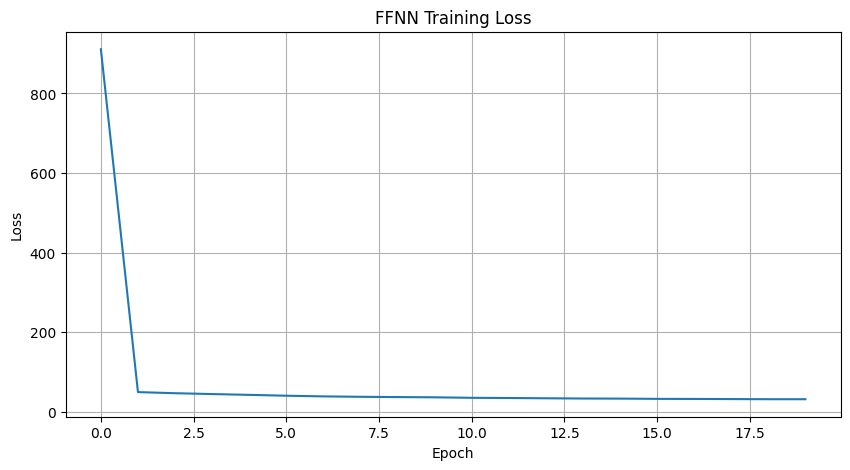

Episode 88/100: Evaluating FFNN
Episode 88/100 | Reward: -1490.9538
Train MSE: 31.2165 | Train Female MSE: 7.2358
Val MSE: 154.7580 | Val Female MSE: 50.4147
Test MSE: 50.9503 | Test Female MSE: 6.5625

--------------------------------

Episode 89/100: Generating Synthetic Data
Episode 89/100: Training FFNN


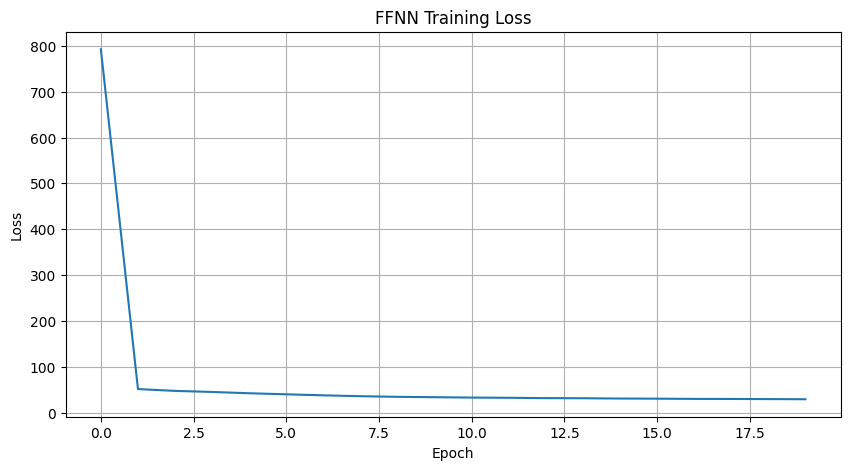

Episode 89/100: Evaluating FFNN
Episode 89/100 | Reward: -1915.4360
Train MSE: 32.2033 | Train Female MSE: 9.2485
Val MSE: 199.5787 | Val Female MSE: 123.4043
Test MSE: 80.4750 | Test Female MSE: 33.9916

--------------------------------

Episode 90/100: Generating Synthetic Data
Episode 90/100: Training FFNN


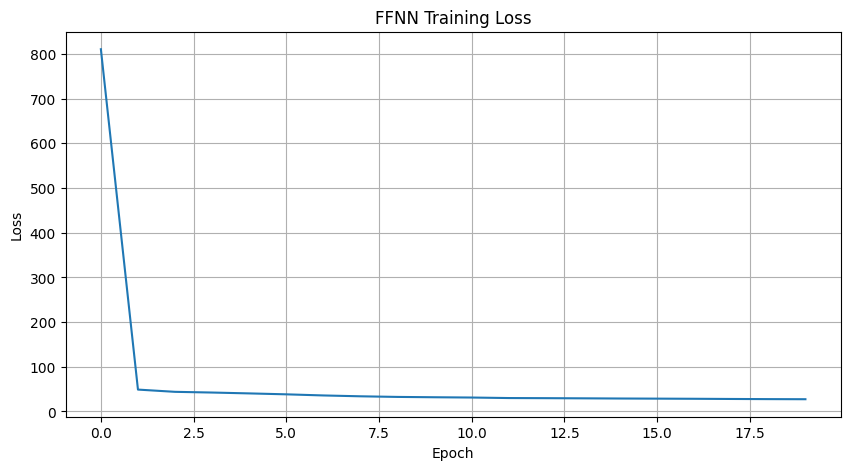

Episode 90/100: Evaluating FFNN
Episode 90/100 | Reward: -1245.2628
Train MSE: 27.5949 | Train Female MSE: 6.3444
Val MSE: 132.9047 | Val Female MSE: 71.1048
Test MSE: 76.3287 | Test Female MSE: 21.1141

--------------------------------

Episode 91/100: Generating Synthetic Data
Episode 91/100: Training FFNN


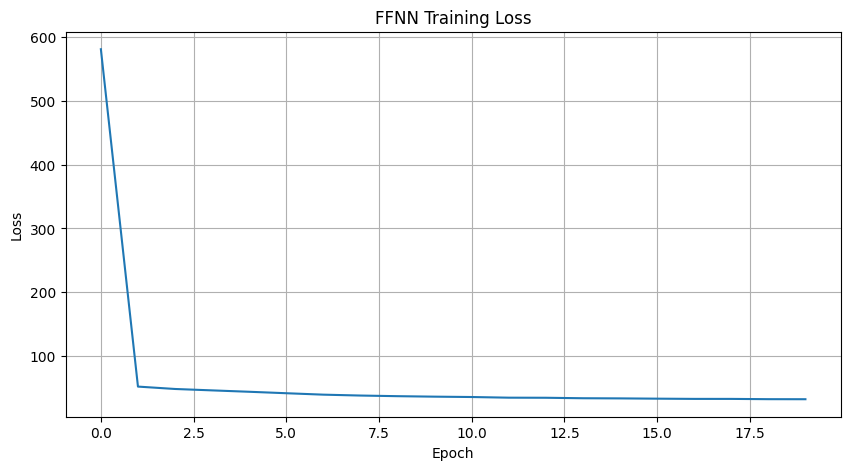

Episode 91/100: Evaluating FFNN
Episode 91/100 | Reward: -2668.2161
Train MSE: 31.3265 | Train Female MSE: 5.1175
Val MSE: 273.1858 | Val Female MSE: 54.2859
Test MSE: 56.6436 | Test Female MSE: 6.7261

--------------------------------

Episode 92/100: Generating Synthetic Data
Episode 92/100: Training FFNN


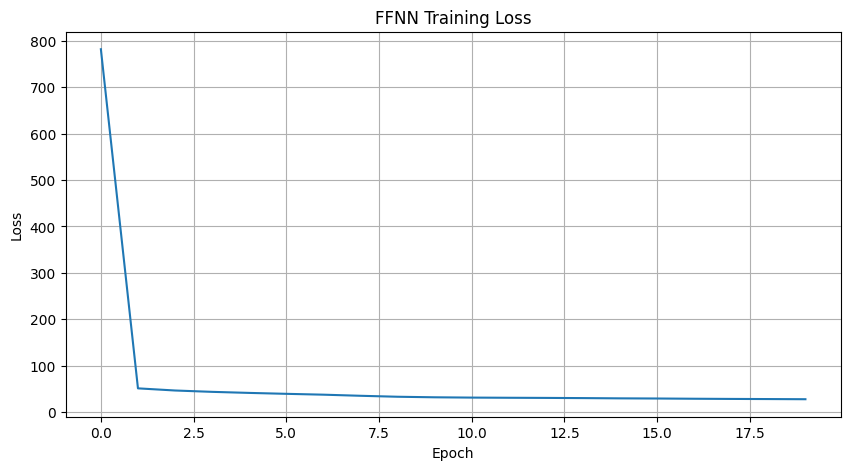

Episode 92/100: Evaluating FFNN
Episode 92/100 | Reward: -2678.0867
Train MSE: 28.6228 | Train Female MSE: 6.6474
Val MSE: 274.6289 | Val Female MSE: 202.8724
Test MSE: 73.4396 | Test Female MSE: 7.4128

--------------------------------

Episode 93/100: Generating Synthetic Data
Episode 93/100: Training FFNN


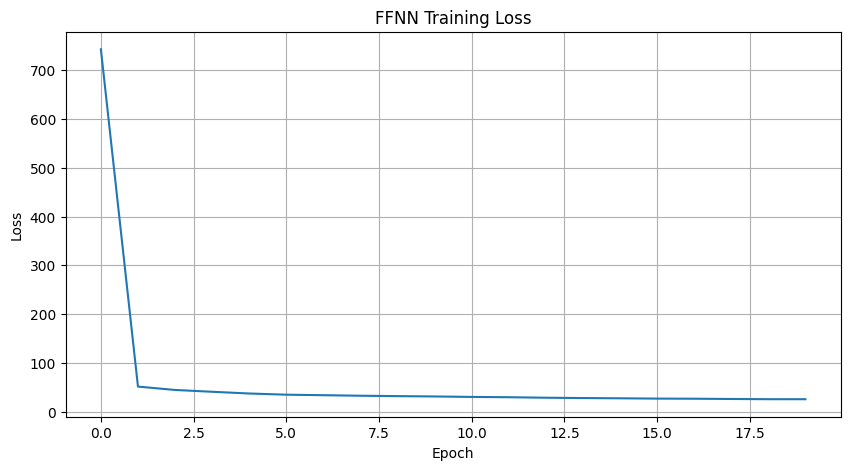

Episode 93/100: Evaluating FFNN
Episode 93/100 | Reward: -1292.0336
Train MSE: 24.4049 | Train Female MSE: 4.3214
Val MSE: 136.4102 | Val Female MSE: 26.0308
Test MSE: 81.2044 | Test Female MSE: 9.7738

--------------------------------

Episode 94/100: Generating Synthetic Data
Episode 94/100: Training FFNN


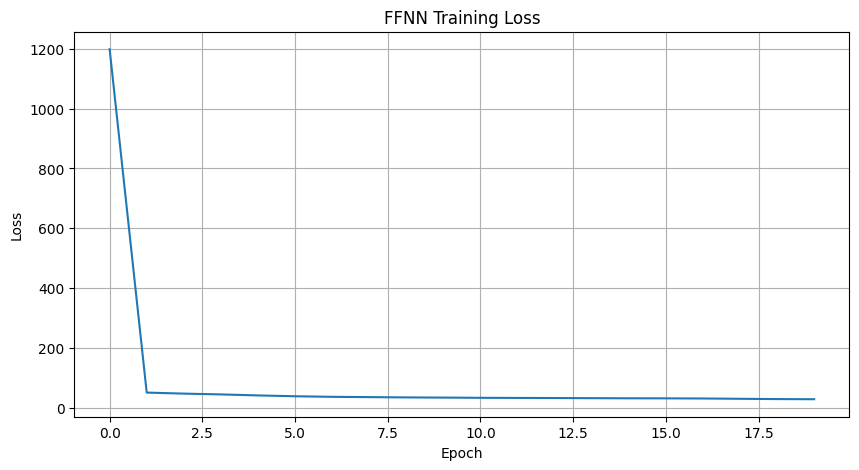

Episode 94/100: Evaluating FFNN
Episode 94/100 | Reward: -797.5931
Train MSE: 29.4539 | Train Female MSE: 8.9665
Val MSE: 87.1733 | Val Female MSE: 30.6523
Test MSE: 68.0114 | Test Female MSE: 28.1071

--------------------------------

Episode 95/100: Generating Synthetic Data
Episode 95/100: Training FFNN


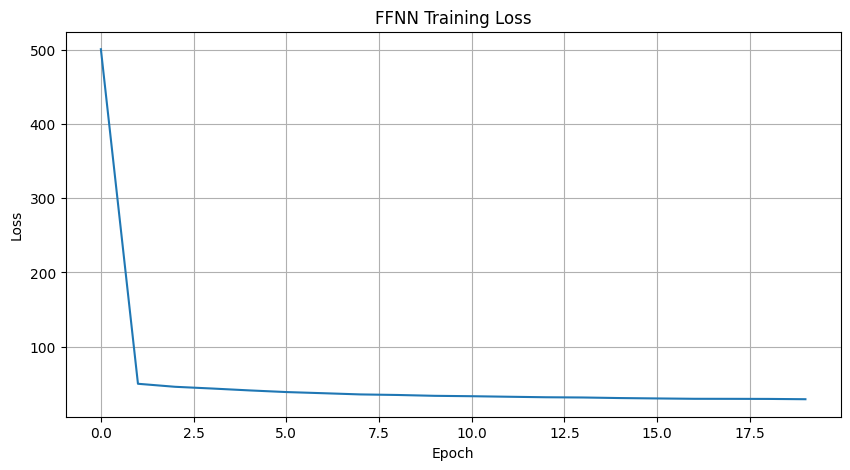

Episode 95/100: Evaluating FFNN
Episode 95/100 | Reward: -2351.8218
Train MSE: 28.8935 | Train Female MSE: 5.5400
Val MSE: 242.6858 | Val Female MSE: 45.3049
Test MSE: 63.8257 | Test Female MSE: 21.5309

--------------------------------

Episode 96/100: Generating Synthetic Data
Episode 96/100: Training FFNN


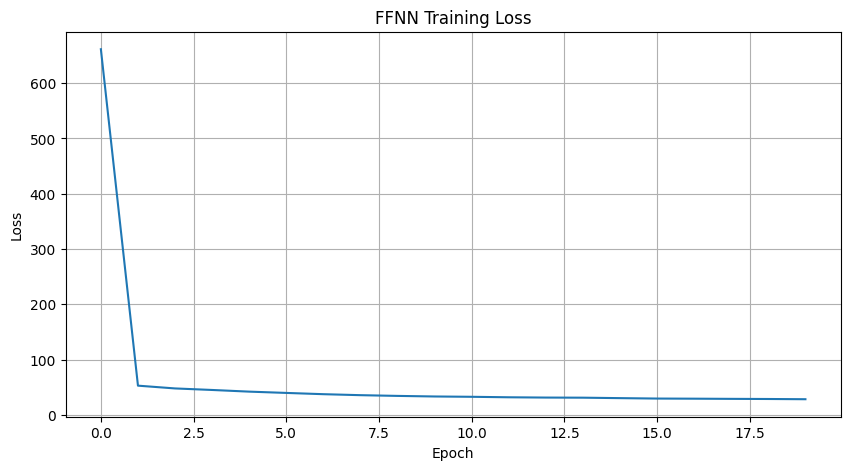

Episode 96/100: Evaluating FFNN
Episode 96/100 | Reward: -1113.4379
Train MSE: 28.2466 | Train Female MSE: 5.6932
Val MSE: 118.8322 | Val Female MSE: 37.5472
Test MSE: 55.4639 | Test Female MSE: 4.9860

--------------------------------

Episode 97/100: Generating Synthetic Data
Episode 97/100: Training FFNN


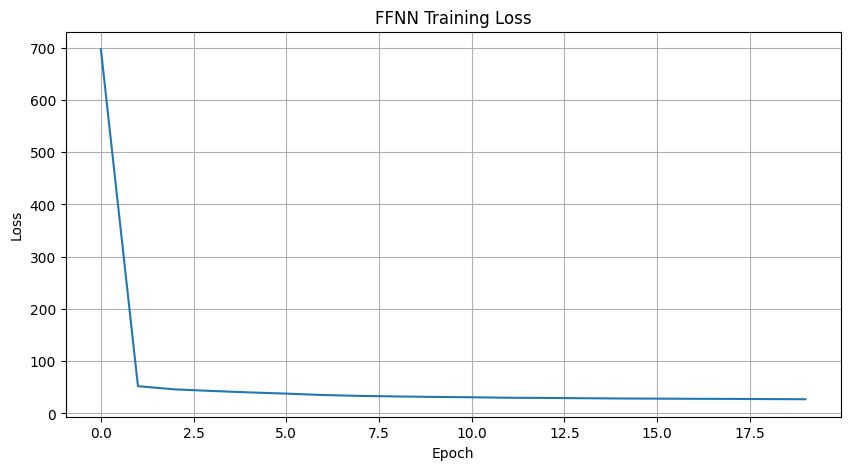

Episode 97/100: Evaluating FFNN
Episode 97/100 | Reward: -787.3425
Train MSE: 26.3525 | Train Female MSE: 5.3637
Val MSE: 86.3976 | Val Female MSE: 32.8220
Test MSE: 42.9999 | Test Female MSE: 7.5546

--------------------------------

Episode 98/100: Generating Synthetic Data
Episode 98/100: Training FFNN


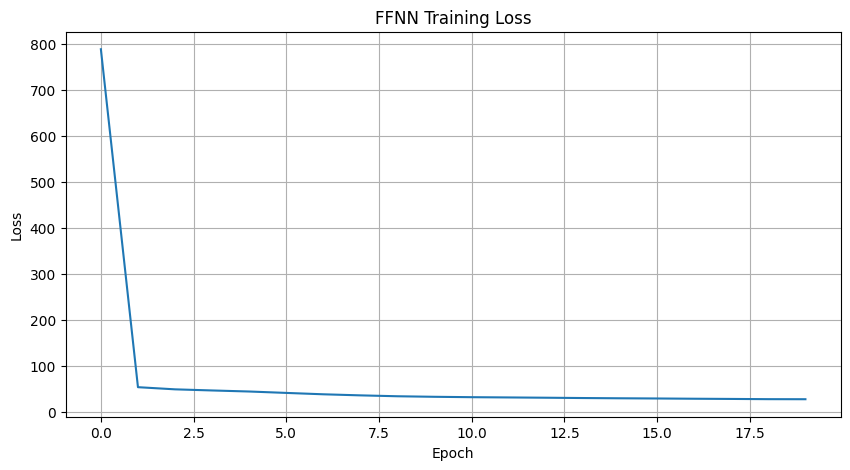

Episode 98/100: Evaluating FFNN
Episode 98/100 | Reward: -1059.2046
Train MSE: 27.3913 | Train Female MSE: 6.0050
Val MSE: 113.4416 | Val Female MSE: 7.8543
Test MSE: 48.2776 | Test Female MSE: 10.4282

--------------------------------

Episode 99/100: Generating Synthetic Data
Episode 99/100: Training FFNN


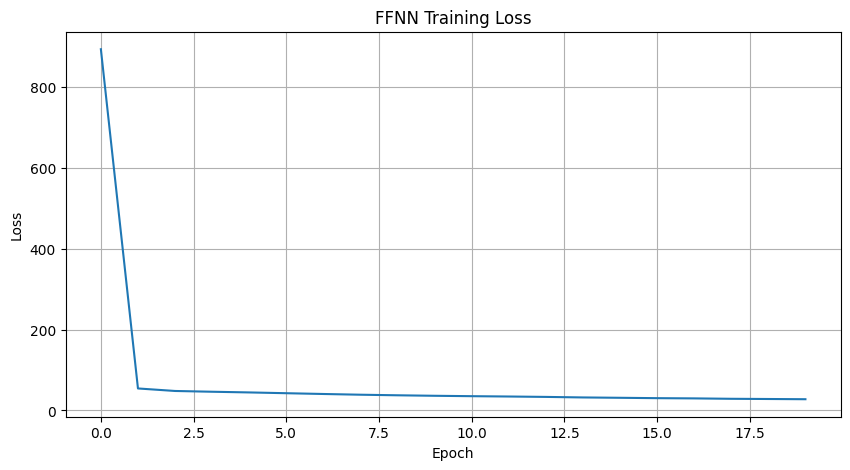

Episode 99/100: Evaluating FFNN
Episode 99/100 | Reward: -2302.3467
Train MSE: 27.6225 | Train Female MSE: 6.6687
Val MSE: 237.5923 | Val Female MSE: 88.4559
Test MSE: 70.6762 | Test Female MSE: 6.0119

--------------------------------

Episode 100/100: Generating Synthetic Data
Episode 100/100: Training FFNN


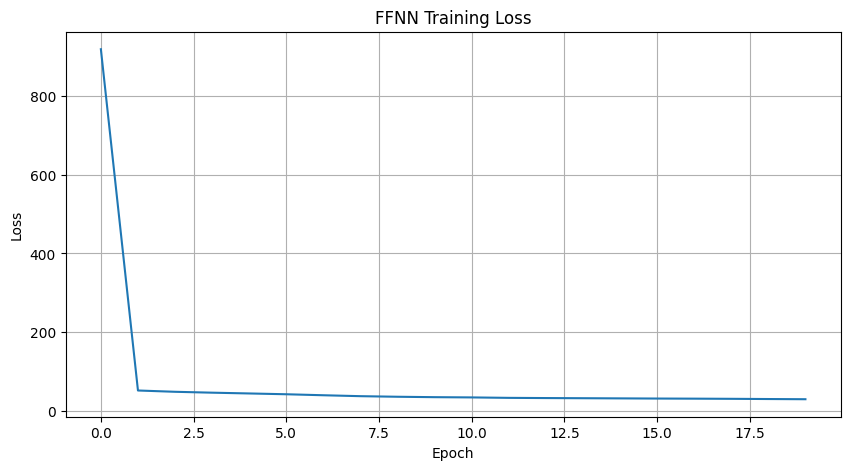

Episode 100/100: Evaluating FFNN
Episode 100/100 | Reward: -1270.6961
Train MSE: 28.3374 | Train Female MSE: 4.7544
Val MSE: 134.3203 | Val Female MSE: 33.4174
Test MSE: 55.0708 | Test Female MSE: 2.3471

--------------------------------

Metrics saved to training_metrics.json
Model saved to dqn_trained_model.pth
Model saved to ppo_trained_model.pth


In [4]:
def evaluate_ffnn(ffnn_agent, data, labels):
    if isinstance(data, (pd.DataFrame, pd.Series)):
        data = data.to_numpy()
    if isinstance(labels, (pd.DataFrame, pd.Series)):
        labels = labels.to_numpy()

    predictions = ffnn_agent.predict(data)

    if isinstance(predictions, torch.Tensor):
        predictions = predictions.detach().cpu().numpy()

    mse = mean_squared_error(labels, predictions)
    mae = mean_absolute_error(labels, predictions)

    # Optional: female-specific evaluation
    female_mask = data[:, -1] == 1
    if female_mask.sum() > 0:
        female_preds = predictions[female_mask]
        female_labels = labels[female_mask]
        female_mse = mean_squared_error(female_labels, female_preds)
    else:
        female_mse = float('nan')

    return mse, mae, female_mse



def plot_ffnn_losses(losses):
    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('FFNN Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    # ages in df = [27, 25, 31, 24, 26, 23]

def generate_state(df, mf_ratio, n_samples):
    timestamp = np.random.uniform(df['Timestamp'].min(), df['Timestamp'].max())
    male_female_ratio = mf_ratio 
    num_samples = n_samples
    age = np.random.uniform(24, 31)
    activity_id = np.random.choice([1, 2])
    return np.array([timestamp, male_female_ratio, num_samples, age, activity_id])


def compute_mini_reward(synthetic_data, mf_ratio):
    column_std = np.std(synthetic_data, axis=0).mean()
    gaussian_penalty = np.exp(-((mf_ratio - 0.5) ** 2) / 0.1)
    return column_std + gaussian_penalty


def train_ffnn_baseline(ffnn_agent, x_train, y_train, x_val, y_val, x_test, y_test):
    # Train on real data only
    print("\nTraining FFNN on real data only (no synthetic data)...")
    losses = ffnn_agent.train(x_train.to_numpy(), y_train.to_numpy())
    plot_ffnn_losses(losses)

    # Evaluate on all splits
    train_mse, train_mae, train_female_mse = evaluate_ffnn(ffnn_agent, x_train, y_train)
    val_mse, val_mae, val_female_mse = evaluate_ffnn(ffnn_agent, x_val, y_val)
    test_mse, test_mae, test_female_mse = evaluate_ffnn(ffnn_agent, x_test, y_test)

    # Print results
    print("\n========== FFNN Baseline (No Synthetic Data) ==========")
    print(f"Train MSE: {train_mse:.4f} | Train MAE: {train_mae:.4f} | Female MSE: {train_female_mse:.4f}")
    print(f"Val   MSE: {val_mse:.4f} | Val   MAE: {val_mae:.4f} | Female MSE: {val_female_mse:.4f}")
    print(f"Test  MSE: {test_mse:.4f} | Test  MAE: {test_mae:.4f} | Female MSE: {test_female_mse:.4f}")
    print("=======================================================\n")

    return {
        "train": (train_mse, train_mae),
        "val": (val_mse, val_mae),
        "test": (test_mse, test_mae),
    }

baseline_results = train_ffnn_baseline(ffnn_agent_og, x_train, y_train, x_val, y_val, x_test, y_test)

def train_agents(x_train, y_train, x_val, y_val, x_test, y_test,
                 dqn_agent, ppo_agent, ffnn_agent, episodes=num_episodes,
                 save_path='training_metrics.json'):

    # Normalize y arrays to shape (n, 1)
    # for var in ['y_train', 'y_val', 'y_test']:
    #     val = locals()[var]
    #     if isinstance(val, pd.Series):
    #         locals()[var] = val.to_numpy().reshape(-1, 1)
    #     elif isinstance(val, pd.DataFrame):
    #         locals()[var] = val.to_numpy()

    rewards = []
    val_accuracies = []
    test_accuracies = []
    train_accuracies = []
    val_female_accuracies = []
    test_female_accuracies = []
    train_female_accuracies = []

    synthetic_data = []
    synthetic_labels = []

    # Initial male-female ratio
    sex_female_idx = x_train.columns.get_loc('Sex - Female')
    mf_ratio = np.mean(x_train.iloc[:, sex_female_idx])
    state = generate_state(x_train, mf_ratio, 0)






    for episode in range(episodes):
        print(f"Episode {episode + 1}/{episodes}: Generating Synthetic Data")
        for i in range(synthetic_data_amount):
            if synthetic_data:
                synthetic_array = np.array(synthetic_data)
                if synthetic_array.ndim == 1:
                    synthetic_array = synthetic_array.reshape(1, -1)
                combined_array = np.vstack([x_train.to_numpy(), synthetic_array])
                combined = pd.DataFrame(combined_array, columns=x_train.columns)
            else:
                combined = x_train.copy()

            sex_female_idx = combined.columns.get_loc('Sex - Female')
            mf_ratio = np.mean(combined.iloc[:, sex_female_idx])

            # Predict actions from RL agents
            discrete_action = np.array(dqn_agent.predict(state), ndmin=1).flatten()

            # First 2 values are features: 'Sex - Female', 'Heart Rate'
            sex_value = discrete_action[0]
            heart_rate = discrete_action[1]

            # Predicted target values: Resting HR, Max HR, Weight, Height (4 values)
            predicted_targets = discrete_action[2:6]

            # Age comes from the state (4th element)
            age_from_state = state[3]

            # Combine into full target: [Resting HR, Max HR, Age, Weight, Height]
            target_values = np.insert(predicted_targets, 2, age_from_state)  # insert age at index 2
            # Resulting shape: (5,) — matches label format

            # Predict continuous features
            continuous_action = np.array(ppo_agent.predict(state), ndmin=1)  # shape (1, num_continuous_features)

            # Create synthetic feature row
            synthetic_row = np.zeros(x_train.shape[1])

            # Get column indices
            discrete_indices = x_train.columns.get_indexer(['Sex - Female', 'Heart Rate'])
            continuous_indices = x_train.columns.get_indexer(continuous_columns)

            # Assign values to synthetic row
            synthetic_row[discrete_indices[0]] = sex_value
            synthetic_row[discrete_indices[1]] = heart_rate
            synthetic_row[continuous_indices] = continuous_action.flatten()

            # Add to synthetic dataset
            synthetic_data.append(synthetic_row)
            synthetic_labels.append(target_values)

            mini_reward = compute_mini_reward(np.array(synthetic_data), mf_ratio)
            done = i == synthetic_data_amount - 1


            if done:
                print(f"Episode {episode + 1}/{episodes}: Training FFNN")
                
                ffnn_agent.reset()

                synthetic_data_np = np.array(synthetic_data)                    # (n_samples, num_features)
                synthetic_labels_np = np.array(synthetic_labels).reshape(-1, 5) # (n_samples, 5)

                combined_data = np.vstack([x_train.to_numpy(), synthetic_data_np])
                combined_labels = np.vstack([y_train, synthetic_labels_np])


                # Shuffle combined training data
                indices = np.arange(combined_data.shape[0])
                np.random.shuffle(indices)
                combined_data = combined_data[indices]
                combined_labels = combined_labels[indices]

                # Train FFNN
                losses = ffnn_agent.train(combined_data, combined_labels)
                plot_ffnn_losses(losses)

                print(f"Episode {episode + 1}/{episodes}: Evaluating FFNN")

                train_mse, train_mae, train_female_mse = evaluate_ffnn(ffnn_agent, x_train, y_train)
                val_mse, val_mae, val_female_mse = evaluate_ffnn(ffnn_agent, x_val, y_val)
                test_mse, test_mae, test_female_mse = evaluate_ffnn(ffnn_agent, x_test, y_test)

                # Reward is based on validation performance and mini reward
                reward = (accuracy_reward_multiplier * val_mse * -1) + (mini_reward)

                train_accuracies.append(train_mse)
                val_accuracies.append(val_mse)
                test_accuracies.append(test_mse)
                train_female_accuracies.append(train_female_mse)
                val_female_accuracies.append(val_female_mse)
                test_female_accuracies.append(test_female_mse)

                print(f"Episode {episode + 1}/{episodes} | Reward: {reward:.4f}")
                print(f"Train MSE: {train_mse:.4f} | Train Female MSE: {train_female_mse:.4f}")
                print(f"Val MSE: {val_mse:.4f} | Val Female MSE: {val_female_mse:.4f}")
                print(f"Test MSE: {test_mse:.4f} | Test Female MSE: {test_female_mse:.4f}")
                print("\n--------------------------------\n")


                synthetic_data = []
                synthetic_labels = []
            else:
                reward = mini_reward

            next_state = generate_state(x_train, mf_ratio, len(synthetic_data) + 1)
            dqn_agent.learn(state, discrete_action, reward, next_state, done)
            ppo_agent.learn(state, continuous_action, reward, next_state, done)

            rewards.append(reward)
            state = next_state

        metrics = {
            'rewards': rewards,
            'train_mse': train_accuracies,
            'val_mse': val_accuracies,
            'test_mse': test_accuracies,
            'train_female_mse': train_female_accuracies,
            'val_female_mse': val_female_accuracies,
            'test_female_mse': test_female_accuracies
        }


    with open(save_path, 'w') as f:
        json.dump(metrics, f)
    print(f"Metrics saved to {save_path}")

    return metrics

# Example usage
results = train_agents(x_train, y_train, x_val, y_val, x_test, y_test, dqn_agent, ppo_agent, ffnn_agent)
dqn_agent.save("dqn_trained_model.pth")
ppo_agent.save("ppo_trained_model.pth")


# Testing


In [5]:
mse, mae, female_mse = evaluate_ffnn(ffnn_agent, x_test, y_test)
print(f"Test Results | MSE: {mse} | MAE: {mae} | Female MSE: {female_mse}")

Test Results | MSE: 55.0707534479767 | MAE: 5.347405940573556 | Female MSE: 2.347124174549681


# Visualize results

In [6]:
# visualize_training([], [])
# visualize_results(dqn_agent, ppo_agent, df)
# visualize_preprocessed_data(df)